# Notebook to analyze the data from AGNs catalogs

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.  
We will analyze the fluxes for the sources.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.io import fits
# from astropy.table import Table
# from astropy.table import Column
# from astropy.table import MaskedColumn
# from astropy.table import hstack
# from astropy.table import vstack
# from astropy.table import join
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import getpass
import progressbar
import pandas as pd
from pandas.plotting import scatter_matrix
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [6]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)
        # mcolors.LogNorm.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

---

## Reading data

In [7]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

It is important to keep in mind that columns with keys starting with `Flux Density...` are in `Jy`.  
All the other values, are expressed in `mJy`.

Columns with uncertainties (`NED Uncertainty...`) have been saved as strings, to preserve possible upper limits.

In [8]:
# large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned.h5', 'df')
# large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned_all_cols.h5', 'df')
large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned_jun2020.h5', 'df')

In [9]:
np.shape(large_catalog_df)

(18168, 1885)

Data could be also converted into `astropy` Tables.

In [10]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [11]:
# np.savetxt(cat_path + 'column_names_flx.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')
# np.savetxt(cat_path + 'column_names_flx_2_5_arcsec.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

From the querying process, some columns have the same identifier.  
In those cases, the suffix `_x` or `_y` has been added (`_x` for `simbad` data, and `_y` for `Ned` photometry).
One example is shown below.

In [12]:
# large_catalog_df.loc[90:100, ['MAIN_ID_x', 'MAIN_ID_y']]

---

## Organize data

Separate data into different arrays for calculations

Repeated keywords are: `MAIN_ID_x`, `MAIN_ID_y`, `COORD_x`, and `COORD_y`

The following redshift column comes from `SDSS` with the highest quality flag selected.

In [13]:
redshift    = large_catalog_df['Z_OWN']
redshift_e  = large_catalog_df['Z_OWN_ERR']
F_20cm      = large_catalog_df['F_20CM']
F_20cm_e    = large_catalog_df['F_20CM_ERR']
F_20cm_up_l = large_catalog_df['L_20CM_UP_LIM']
origin_flag = large_catalog_df['ORIGIN'].astype(int)         # 0:SDSS+FIRST, 1:COSMOS, 2:RADIO, 3:Inayoshi

We can calculate luminosities from fluxes.

In this case, we first select the columns with fluxes in a numerical format  
(with this all error columns are discarded for the moment).

In [14]:
# numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'FLUX_ERROR_B',\
#                                                                            'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
#                                                                            'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
#                                                                            'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
#                                                                            'FLUX_ERROR_K', 'Z_OWN'])
numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'FLUX_ERROR_B',\
                                                                           'FLUX_ERROR_V', 'FLUX_ERROR_R', 'FLUX_ERROR_I', 'FLUX_ERROR_J',\
                                                                           'FLUX_ERROR_K','F_250GHZ_ERR', 'F_XMM_ERR','F_1.5GHZ_ERR',\
                                                                           'F_3GHZ_ERR', 'MASS_1450', 'F_20CM_ERR', 'Z_OWN_ERR', 'Z_OWN',\
                                                                           'F_6CM_ERR'])
#numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'D_LUM', 'FLUX_ERROR_B',\
#                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
#                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
#                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
#                                                                           'FLUX_ERROR_K', 'JOINED_F_14GHZ', 'TEST_14_LUM',\
#                                                                           'Z_OWN'])

We create a new `pandas` `DataFrame` object to contain our fluxes,  
and we put them in the same units (`mJy`).

In [15]:
flux_catalog_df                       = pd.DataFrame()

In [16]:
for col_name in numeric_col_names:
    if 'F_' in col_name:
        flux_col_name                  = col_name.replace('F_', 'FLUX_')
        flux_catalog_df[flux_col_name] = large_catalog_df[col_name]
    if 'FLUX_' in col_name:
        flux_col_name                  = col_name.replace('FLUX_', 'FLUX_')
        flux_catalog_df[flux_col_name] = large_catalog_df[col_name]
    if 'Flux Density' in col_name:
        flux_col_name                  = col_name.replace('Flux Density', 'Flux')
        flux_catalog_df[flux_col_name] = large_catalog_df[col_name] * 1e3 

For future use and reference, we can add new columns to the original catalog. 

In [17]:
flx_catalog_cols = flux_catalog_df.columns

One such column contains luminosity distances calculated from redshift values.

In [18]:
# large_catalog_df['D_LUM']           = cosmo.luminosity_distance(large_catalog_df['Z_OWN']).to(u.m).value

As before, we can create a file to save the names of this new table with luminosities

In [19]:
# np.savetxt(cat_path + 'column_names_lum.txt', lums_catalog_df.columns, fmt='%s', delimiter='\n')

Only for calculation purposes, we can show the luminosity columns with the ($10$) highest number of elements.

In [20]:
stats_flux  = pd.DataFrame(flux_catalog_df.describe().loc['count'])
counts_flux = stats_flux.sort_values('count', ascending=False)
counts_flux[:10]

,count
FLUX_20CM,18102.0
Flux W1 (WISE),10483.0
Flux g (SDSS PSF) AB,10191.0
Flux z (SDSS PSF) AB,10191.0
Flux i (SDSS PSF) AB,10191.0
Flux r (SDSS PSF) AB,10191.0
Flux u (SDSS PSF) AB,10169.0
Flux W2 (WISE),9887.0
FLUX_V,9079.0
FLUX_3GHZ,8995.0


We can also attempt to merge the values from some columns. This can be done with features  
observed in similar (or equal) frequencies.

In order to do this, we can first import a list of all the used Passbands used in our table  
with their frequencies (Only measurements from `Ned`).

In [21]:
# band_names = np.loadtxt(cat_path + 'all_ned_band_names.txt', usecols=[0], dtype=np.str, delimiter='\t')
# band_freqs = np.loadtxt(cat_path + 'all_ned_band_names.txt', usecols=[1], dtype=np.float, delimiter='\t')
# band_names = np.loadtxt(cat_path + 'all_ned_band_names_2_5arcsec.txt', usecols=[0], dtype=np.str, delimiter='\t')
# band_freqs = np.loadtxt(cat_path + 'all_ned_band_names_2_5arcsec.txt', usecols=[1], dtype=np.float, delimiter='\t')

If the file `all_ned_band_names_2_5arcsec.txt` is used, a different approach  
should be used.

In [22]:
# band_names_freqs_file = 'all_ned_band_names_2_5arcsec.txt'
band_names_freqs_file = 'all_ned_band_names_jun2020.txt'

In [23]:
with open(band_names_freqs_file, encoding='utf-8') as fp:  # Data already sorted by frequency
    lines_bands = fp.readlines()

In [24]:
band_names = []
band_freqs = []

In [25]:
for line in lines_bands:
    line    = line.strip()
    line_sp = line.split(' ')
    name    = ' '.join(line_sp[:-1])
    freq    = np.float(line_sp[-1])
    if name in band_names: continue
    band_names.append(name)
    band_freqs.append(freq)
band_names_temp  = np.array(band_names)
band_freqs_temp  = np.array(band_freqs)  # Frequencies sorted alphabetically (as strings)
band_names       = band_names_temp[np.argsort(band_freqs_temp)]
band_freqs       = band_freqs_temp[np.argsort(band_freqs_temp)]

These bands can be ordered by observed frequency.

In [26]:
np.shape(band_freqs)

(924,)

In [27]:
band_names_ord      = band_names
band_freqs_ord      = band_freqs
band_freqs_ord_2d   = np.c_[band_freqs_ord, np.zeros_like(band_freqs_ord)]  # Make it a 2-D array for future calculations

In [28]:
band_names_flux     = np.array(['Flux ' + band_name for band_name in band_names])
band_names_ord_flux = np.array(['Flux ' + band_name for band_name in band_names_ord])

In [29]:
lums_band_names_freqs_pd = pd.Series(band_names_ord_flux, index=band_freqs_ord)

Repeat procedure used to obtain data table: join features with almost identical passband names.

In [30]:
np.shape(np.unique(band_names_flux))

(924,)

Now, there are no repeated exact names in the bands list.

In [31]:
np.shape(flux_catalog_df)

(18168, 936)

Calculate pair-wise distance among all frequencies (output is a matrix)

In [32]:
band_freqs_dists  = pd.DataFrame(data=distance.squareform(distance.pdist(band_freqs_ord_2d, metric='euclidean')),\
                                index=band_names_flux, columns=band_names_flux)

Group features with similar names and frequencies very close to each other.

In [33]:
band_names_groups_orig  = []
band_names_groups_repl  = []
used_band_names         = []
for index, (band_name, band_freq) in enumerate(zip(band_names_flux, band_freqs)):
    # str_to_search = ' '.join(re.findall(r'[A-Za-z]+|\d*[.,-]?\d+', re.sub(r' \(.*', '', str(band_name)).strip()))
    if band_name not in list(itertools.chain.from_iterable(band_names_groups_orig)):
        used_band_names.append(band_name)
        filter_dist = (band_freqs_dists[band_name] < 2.5)  # 2.5 % difference between band frequencies
        if np.ndim(filter_dist) > 1:
            filter_dist = filter_dist.iloc[:, 0]
        band_names_groups_orig.append(band_names_flux[filter_dist].tolist())
#        band_names_groups_repl.append(['Luminosity ' + re.sub(r' \(.*', '', name).strip()\
#                                       for name in band_names_ord[filter_dist].tolist()\
#                                      if 'Luminosity ' + re.sub(r' \(.*', '', name).strip() in lf_catalog_cols])

Create new table with luminosities. Features from the previously defined groups will be averaged and saved as  
one single column.

In [34]:
pre_merged_flux_catalog_df = pd.DataFrame()
for element in band_names_groups_orig:
    if len(element) == 0: continue
    if len(element) == 1: 
        pre_merged_flux_catalog_df[element] = flux_catalog_df[element]
        continue
    # lums_catalog_df[np.unique(band_names_groups_repl[0], axis=0)].describe()
    test_table = flux_catalog_df[np.unique(element, axis=0)].median(axis='columns', skipna=True)
    # test_table = test_table.rename(np.unique(element, axis=0)[0])
    pre_merged_flux_catalog_df[np.unique(element, axis=0)[0]] = test_table

/home/rcarvajal/.miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Now, the same procedure. But to merge features with similar names (a match before the parenthesis).

In [35]:
# band_names_groups_orig

In [36]:
pre_merged_column_names = pre_merged_flux_catalog_df.columns

In [37]:
band_names_groups_trim_dict = {}
# band_names_groups_repl  = []
used_band_names_trim        = []
for index, band_name in enumerate(pre_merged_column_names):
    str_to_search = ' '.join(re.findall(r'[A-Za-z]+|\d*[.,-]?\d+', re.sub(r' \(.*', '', str(band_name)).strip()))
    if str_to_search not in used_band_names_trim:
        band_names_groups_trim_dict[str_to_search] = [band_name]
    if str_to_search in used_band_names_trim:
        band_names_groups_trim_dict[str_to_search].append(band_name)
    used_band_names_trim.append(str_to_search)

In [38]:
band_names_groups_trim = []
for key in band_names_groups_trim_dict:
    band_names_groups_trim.append(band_names_groups_trim_dict[key])

In [39]:
merged_flux_catalog_df = pd.DataFrame()

for key in band_names_groups_trim_dict:
    merged_flux_catalog_df[key] = pre_merged_flux_catalog_df[band_names_groups_trim_dict[key]].median(axis='columns', skipna=True)

Merge more columns by hand.

In [40]:
# merged_lums_catalog_df.columns.to_numpy()

In [41]:
# 'Luminosity 10 MHz', 'Luminosity 22.25 MHz', 'Luminosity 22 MHz', 'Luminosity 26.3 MHz', 'Luminosity 38 MHz', 'Luminosity 60 MHz', 'Luminosity 74 MHz', 'Luminosity 80 MHz', 'Luminosity 86 MHz', 'Luminosity 111 MHZ', 'Luminosity 145 MHz', 'Luminosity 150 MHz', 'Luminosity 151 MHz', 'Luminosity 153 MHz', 'Luminosity 160 MHz', 'Luminosity 178 MHz', 'Luminosity 230 MHz', 'Luminosity 235 MHz', 'Luminosity 240 MHz', 'Luminosity 0.302 GHz', 'Luminosity 318 MHz', 'Luminosity 320.2 MHz', 'Luminosity 324 MHz', 'Luminosity 324.5 MHz', 'Luminosity 327 MHz', 'Luminosity 332 MHz', 'Luminosity 0.333 GHz', 'Luminosity 336.4 MHz', 'Luminosity 340 MHz', 'Luminosity 365 MHz', 'Luminosity 0.408 GHz', 'Luminosity 408 MHz', 'Luminosity 430 MHz', 'Luminosity 468 MHz', 'Luminosity 599.07 MHz', 'Luminosity 601.71 MHz', 'Luminosity 606 MHz', 'Luminosity 0.608 GHz', 'Luminosity 609 MHz', 'Luminosity 610 MHz', 'Luminosity 635 MHz', 'Luminosity 700.02 MHz', 'Luminosity 750 MHz', 'Luminosity 751.50 MHz', 'Luminosity 762.84 MHz', 'Luminosity 767.04 MHz', 'Luminosity 785.80 MHz', 'Luminosity 0.960 GHz', 'Luminosity 966 MHz', 'Luminosity 31 cm', 'Luminosity 968 MHz', 
# 'Luminosity 1.335 GHz', 'Luminosity 1.365 GHz', 'Luminosity 1.38 GHz', 'Luminosity 1.4 GHz', 'Luminosity 1.408 GHz', 'Luminosity 1.418 GHz', 'Luminosity 1484 MHz', 'Luminosity 1.49 GHz', 'Luminosity 20 cm', 'Luminosity 1.6 GHz', 'Luminosity 1.65 GHz', 'Luminosity 1.66 GHz', 'Luminosity 1.7 GHz',
# 'Luminosity 2.2 GHz', 'Luminosity 2 GHz', 'Luminosity 2263 MHz', 'Luminosity 2.3 GHz', 'Luminosity 2.5 GHz', 'Luminosity 2.64 GHz Effelsberg', 'Luminosity 2650 MHz', 'Luminosity 2.70 GHz Effelsberg', 
# 'Luminosity 3.1 GHz', 'Luminosity 3.9 GHz', 'Luminosity 7.6 cm', 'Luminosity 4.5 GHz', 'Luminosity 4.535 GHz', 'Luminosity 4585 MHz', 'Luminosity 4775 MHz', 'Luminosity 4.8 GHz', 'Luminosity 4830 MHz', 'Luminosity 4.85 GHz', 'Luminosity 4.86 GHz', 'Luminosity 4885 MHz', 'Luminosity 4.89 GHz', 'Luminosity 4.9 GHz', 'Luminosity 4.985 GHz', 'Luminosity 4.99 GHz', 'Luminosity 5 GHz', 'Luminosity 5009 MHz', 'Luminosity 5.5 GHz',
# 'Luminosity 7.700 GHz', 'Luminosity 8 GHz', 'Luminosity 8.085 GHz', 'Luminosity 8.1 GHz', 'Luminosity 8.35 GHz Effelsberg', 'Luminosity 8.4 GHz', 'Luminosity 8.44 GHz', 'Luminosity 8.46 GHz', 'Luminosity 8.48 GHz', 'Luminosity 8.5 GHz', 'Luminosity 8.6 GHz', 'Luminosity 8870 MHz', 'Luminosity 9.0 GHz', 'Luminosity 10.45 GHz', 'Luminosity 10.6 GHz Effelsberg', 'Luminosity 10.7 GHz', 'Luminosity 11.200 GHz', 'Luminosity 14 GHz', 'Luminosity 14.60 GHz Effelsberg', 'Luminosity 14.9 GHz', 'Luminosity 14.96 GHz', 'Luminosity 15.1 GHz', 'Luminosity 15.2 GHz', 'Luminosity 15.3 GHz', 'Luminosity 15.7 GHz', 'Luminosity 16.1 GHz', 'Luminosity 17 GHz', 'Luminosity 20 GHz', 'Luminosity 22 GHz', 'Luminosity 22.46 GHz', 'Luminosity 23 GHz', 'Luminosity 23.05 GHz Effelsberg', 'Luminosity 24 GHz', 'Luminosity 24.4 GHz', 'Luminosity 28.5 GHz', 'Luminosity 30 GHz', 'Luminosity 31 GHz', 'Luminosity 31400 MHz', 'Luminosity 32 GHz', 'Luminosity 33 GHz', 'Luminosity 34 GHz', 'Luminosity 37 GHz', 'Luminosity 38 GHz', 'Luminosity 41 GHz', 'Luminosity 41.5 GHz', 'Luminosity 42.00 GHz Effelsberg', 'Luminosity 43 GHz', 'Luminosity 43.1 GHz', 'Luminosity 43.2 GHz', 'Luminosity 43.34 GHz', 'Luminosity 43.4 GHz', 'Luminosity 44 GHz', 'Luminosity 61 GHz', 'Luminosity 70 GHz', 'Luminosity 77 GHz', 'Luminosity 81.551 GHz', 'Luminosity 86 GHz', 'Luminosity 86.9 GHz', 'Luminosity 87.3 GHz', 'Luminosity 89600 MHz', 'Luminosity 90 GHz', 'Luminosity 94 GHz', 'Luminosity 3 mm', 'Luminosity 100 GHz', 'Luminosity 105.4 GHz', 'Luminosity 136.2 GHz', 'Luminosity 143 GHz', 'Luminosity 150 GHz', 'Luminosity 163.088 GHz', 
# 'Luminosity 203.850 GHz', 'Luminosity 215 GHz', 'Luminosity 226 GHz', 'Luminosity 229 GHz', 'Luminosity 1.3 mm', 'Luminosity 1300 microns', 'Luminosity 1.25 mm', 'Luminosity 244.603 GHz', 'Luminosity 1.2 mm', 'Luminosity 270 GHz', 'Luminosity 1.1 mm', 'Luminosity 300 GHz', 'Luminosity 962 microns', 'Luminosity CO 3-2', 'Luminosity 890 microns', 'Luminosity 345 GHz', 'Luminosity 350 GHz', 'Luminosity 850 microns', 'Luminosity 375 GHz', 
# 'Luminosity 500 microns Herschel', 'Luminosity 500 microns', 'Luminosity 450 microns', 'Luminosity CO 6-5', 'Luminosity 350 microns', 'Luminosity 250 microns Herschel', 'Luminosity 250 microns', 'Luminosity 200 microns', 'Luminosity 170 microns', 'Luminosity 170 microns Herschel', 'Luminosity 160 microns', 'Luminosity 150 microns', 'Luminosity C II 158', 
# 'Luminosity 100 microns', 'Luminosity 100 microns Herschel', 'Luminosity 90 microns', 'Luminosity 70 microns', 'Luminosity O I', 'Luminosity 60 microns', 'Luminosity 30 microns', 'Luminosity H 2 S 0 line', 'Luminosity Fe II 15.99', 'Luminosity O IV', 'Luminosity 25 microns', 'Luminosity Ne V 24.32', 'Luminosity 24 microns', 'Luminosity 22 microns', 'Luminosity Q', 'Luminosity 20 microns', 'Luminosity S III 18.7', 'Luminosity L 18 W', 'Luminosity 18 microns', 'Luminosity H 2 S 1 line', 'Luminosity 16 microns', 'Luminosity NeIII 15.6 microns', 'Luminosity Ne III 15.5', 'Luminosity 15 microns', 'Luminosity Cl II 14.37', 'Luminosity Ne V', 'Luminosity 12.8 microns', 'Luminosity HI 7-6', 'Luminosity H 2 S 2 line', 'Luminosity 12 microns', 'Luminosity 12.0 microns', 'Luminosity W 3', 'Luminosity 11.3 microns', 'Luminosity PAH 11.2', 'Luminosity 11 microns', 'Luminosity S IV 10.51', 'Luminosity S IV 10.5', 'Luminosity S 11', 'Luminosity N', 'Luminosity 10 microns', 'Luminosity log nu Hz 13.48', 'Luminosity H 2 S 3 line', 'Luminosity Ar III 8.99',
# 'Luminosity 8 microns', 'Luminosity 7.9 microns Spitzer', 'Luminosity 8.0 microns', 'Luminosity 7.7 microns', 'Luminosity 7.3 microns', 'Luminosity 6.7 microns', 'Luminosity PAH 6.2', 'Luminosity 6 microns', 'Luminosity 5.8 microns', 'Luminosity H 2 S 7 line', 'Luminosity 5.5 microns Spitzer', 'Luminosity 5 microns', 'Luminosity 4.8 microns', 'Luminosity W 2', 'Luminosity 4.6 microns', 'Luminosity 4.5 microns', 'Luminosity N 4', 'Luminosity L', 'Luminosity 3.7 microns', 'Luminosity 3.6 microns', 'Luminosity log nu Hz 13.934', 'Luminosity 3.4 microns', 'Luminosity W 1', 'Luminosity 3 microns',
# 'Luminosity K', 'Luminosity HK', 
# 'Luminosity H', 'Luminosity F 160 W', 
# 'Luminosity J', 'Luminosity z', 'Luminosity O I 11287', 'Luminosity log nu Hz 14.45',
# 'Luminosity Y', 
# 'Luminosity Z', 'Luminosity log nu Hz 14.50', 'Luminosity F 850 LP', 
# 'Luminosity I', 'Luminosity Z aper', 'Luminosity O I 8446', 
# 'Luminosity F 814 W', 'Luminosity F 775 W', 'Luminosity i', 'Luminosity log nu Hz 14.60', 
# 'Luminosity R', 'Luminosity F 702 W', 'Luminosity S II 6716', 'Luminosity log nu Hz 14.65', 'Luminosity CCD grism r 4', 'Luminosity N II', 'Luminosity H alpha', 'Luminosity r', 'Luminosity 103 a E', 'Luminosity O I 6300', 
# 'Luminosity F 606 W', 'Luminosity log nu Hz 14.70', 'Luminosity Na I He I', 'Luminosity V', 'Luminosity F 555 W', 'Luminosity log nu Hz 14.75',
# 'Luminosity g', 'Luminosity 5100 A', 'Luminosity O III', 'Luminosity O III 4960', 'Luminosity O III 4959', 'Luminosity 4861 A', 'Luminosity G', 'Luminosity log nu Hz 14.80', 'Luminosity b J', 'Luminosity Photographic IIIa J', 'Luminosity Fe II 4570', 
# 'Luminosity B', 'Luminosity O III 4363', 'Luminosity H gamma', 'Luminosity log nu Hz 14.85', 'Luminosity B W', 'Luminosity H delta 4101', 'Luminosity 103 a O', 'Luminosity N 396 12', 'Luminosity Ne III 3869', 
# 'Luminosity u', 'Luminosity log nu Hz 14.90', 'Luminosity U', 'Luminosity O II 3727', 'Luminosity U aper', 'Luminosity Ne V 3425', 'Luminosity log nu Hz 14.95',
# 'Luminosity 3000 A', 'Luminosity Fe II line', 'Luminosity UVW 1', 'Luminosity Mg II', 'Luminosity 2500 A', 'Luminosity NUV', 'Luminosity NUV max', 'Luminosity UVM 2', 'Luminosity UVW 2',
# 'Luminosity C III 1909', 'Luminosity Si III 1892', 'Luminosity 1700 A', 'Luminosity He II 1640', 'Luminosity C IV line', 'Luminosity 1549 A', 'Luminosity FUV', 'Luminosity FUV max', 
# 'Luminosity Si IV O IV', 'Luminosity 1350 A', 'Luminosity O I 1304', 'Luminosity 1280 A', 'Luminosity N V 1240', 'Luminosity Ly alpha', 'Luminosity 1030 A', 'Luminosity 1000 A', 'Luminosity 830 A', 
# 'Luminosity 0.5 -1 keV', 'Luminosity 1 keV', 'Luminosity 0.2 -2 keV', 'Luminosity 0.3 -2 keV', 'Luminosity 0.1 -2 .4 keV', 'Luminosity 0.7 -2 keV', 'Luminosity 0.3 -2 .5 keV Chandra', 'Luminosity 0.5 -2 .5 keV Chandra', 'Luminosity 0.3 -3 .5 keV', 'Luminosity 0.15 -3 .5 keV', 'Luminosity 0.3 -3 .5 keV Einstein', 'Luminosity 2 keV', 'Luminosity 0.5 -4 .5 keV', 'Luminosity 2.0 -4 keV', 'Luminosity 2-4 .5 keV', 'Luminosity 0.5 -7 keV', 'Luminosity 0.7 -7 keV', 'Luminosity 4 keV', 'Luminosity 0.3 -8 keV', 'Luminosity 0.35 -8 keV', 'Luminosity 0.5 -8 keV', 'Luminosity 2-7 keV', 'Luminosity 0.5 -10 keV', 'Luminosity 0.2 -10 keV', 'Luminosity 0.3 -10 keV', 'Luminosity 2-10 keV', 'Luminosity 0.2 -12 keV', 'Luminosity 6.4 keV Fe K alpha', 'Luminosity 3-10 keV', 'Luminosity 5-10 keV', 
# 'Luminosity 20-40 keV', 'Luminosity 15-55 keV', 'Luminosity 17-60 keV', 'Luminosity 20-60 keV', 'Luminosity 20-100 keV INTEGRAL', 'Luminosity 40-100 keV INTEGRAL', 'Luminosity 15-150 keV', 'Luminosity 14-195 keV', 
# 'Luminosity EGRET', 'Luminosity 0.1 -100 GeV'

In [42]:
new_name  = 'Flux 10-968 MHz'  # 'Flux 324 MHz'
old_names = ['Flux 10 MHz', 'Flux 22.25 MHz', 'Flux 22 MHz', 'Flux 26.3 MHz', 'Flux 38 MHz',\
             'Flux 60 MHz', 'Flux 74 MHz', 'Flux 80 MHz', 'Flux 86 MHz', 'Flux 111 MHZ',\
             'Flux 145 MHz', 'Flux 150 MHz', 'Flux 151 MHz', 'Flux 153 MHz', 'Flux 160 MHz',\
             'Flux 178 MHz', 'Flux 230 MHz', 'Flux 235 MHz', 'Flux 240 MHz',\
             'Flux 0.302 GHz', 'Flux 318 MHz', 'Flux 320.2 MHz', 'Flux 324.5 MHz',\
             'Flux 327 MHz', 'Flux 332 MHz', 'Flux 0.333 GHz', 'Flux 336.4 MHz', 'Flux 340 MHz',\
             'Flux 365 MHz', 'Flux 0.408 GHz', 'Flux 408 MHz', 'Flux 430 MHz', 'Flux 468 MHz',\
             'Flux 599.07 MHz', 'Flux 601.71 MHz', 'Flux 606 MHz', 'Flux 0.608 GHz', 'Flux 609 MHz',\
             'Flux 610 MHz', 'Flux 635 MHz', 'Flux 700.02 MHz', 'Flux 750 MHz', 'Flux 751.50 MHz',\
             'Flux 762.84 MHz', 'Flux 767.04 MHz', 'Flux 785.80 MHz', 'Flux 0.960 GHz',\
             'Flux 966 MHz', 'Flux 31 cm', 'Flux 968 MHz']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [43]:
new_name  = 'Flux 1.4-1.7 GHz'
old_names = ['Flux 1.4 GHz', 'Flux 1.335 GHz', 'Flux 1.365 GHz', 'Flux 1.38 GHz', 'Flux 1.408 GHz',\
             'Flux 1.418 GHz', 'Flux 1484 MHz', 'Flux 1.49 GHz', 'Flux 20 cm', 'Flux 1.6 GHz',\
             'Flux 1.65 GHz', 'Flux 1.66 GHz', 'Flux 1.7 GHz']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [44]:
new_name  = 'Flux 2.2-5.5 GHz'
old_names = ['Flux 2.2 GHz', 'Flux 2 GHz', 'Flux 2263 MHz', 'Flux 2.3 GHz', 'Flux 2.5 GHz',\
             'Flux 2.64 GHz Effelsberg', 'Flux 2650 MHz', 'Flux 2.70 GHz Effelsberg', 'Flux 3.1 GHz',\
             'Flux 3.9 GHz', 'Flux 7.6 cm', 'Flux 4.5 GHz', 'Flux 4.535 GHz',\
             'Flux 4585 MHz', 'Flux 4775 MHz', 'Flux 4.8 GHz', 'Flux 4830 MHz', 'Flux 4.85 GHz',\
             'Flux 4.86 GHz', 'Flux 4885 MHz', 'Flux 4.89 GHz', 'Flux 4.9 GHz', 'Flux 4.985 GHz',\
             'Flux 4.99 GHz', 'Flux 5 GHz', 'Flux 5009 MHz', 'Flux 5.5 GHz']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [45]:
new_name  = 'Flux 7.7-163.1 GHz'
old_names = ['Flux 7.700 GHz', 'Flux 8 GHz', 'Flux 8.085 GHz', 'Flux 8.1 GHz',\
             'Flux 8.35 GHz Effelsberg', 'Flux 8.4 GHz', 'Flux 8.44 GHz', 'Flux 8.46 GHz',\
             'Flux 8.48 GHz', 'Flux 8.5 GHz', 'Flux 8.6 GHz', 'Flux 8870 MHz', 'Flux 9.0 GHz',\
             'Flux 10.45 GHz', 'Flux 10.6 GHz Effelsberg', 'Flux 10.7 GHz', 'Flux 11.200 GHz',\
             'Flux 14 GHz', 'Flux 14.60 GHz Effelsberg', 'Flux 14.9 GHz', 'Flux 14.96 GHz',\
             'Flux 15.1 GHz', 'Flux 15.2 GHz', 'Flux 15.3 GHz', 'Flux 15.7 GHz', 'Flux 16.1 GHz',\
             'Flux 17 GHz', 'Flux 20 GHz', 'Flux 22 GHz', 'Flux 22.46 GHz', 'Flux 23 GHz',\
             'Flux 23.05 GHz Effelsberg', 'Flux 24 GHz', 'Flux 24.4 GHz', 'Flux 28.5 GHz', 'Flux 30 GHz',\
             'Flux 31 GHz', 'Flux 31400 MHz', 'Flux 32 GHz', 'Flux 33 GHz', 'Flux 34 GHz',\
             'Flux 37 GHz', 'Flux 38 GHz', 'Flux 41 GHz', 'Flux 41.5 GHz', 'Flux 42.00 GHz Effelsberg',\
             'Flux 43 GHz', 'Flux 43.1 GHz', 'Flux 43.2 GHz', 'Flux 43.34 GHz', 'Flux 43.4 GHz',\
             'Flux 44 GHz', 'Flux 61 GHz', 'Flux 70 GHz', 'Flux 77 GHz', 'Flux 81.551 GHz',\
             'Flux 86 GHz', 'Flux 86.9 GHz', 'Flux 87.3 GHz', 'Flux 89600 MHz', 'Flux 90 GHz',\
             'Flux 94 GHz', 'Flux 3 mm', 'Flux 100 GHz', 'Flux 105.4 GHz', 'Flux 136.2 GHz',\
             'Flux 143 GHz', 'Flux 150 GHz', 'Flux 163.088 GHz']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [46]:
new_name  = 'Flux 203-375 GHz'
old_names = ['Flux 203.850 GHz', 'Flux 215 GHz', 'Flux 226 GHz', 'Flux 229 GHz', 'Flux 1.3 mm',\
             'Flux 1300 microns', 'Flux 1.25 mm', 'Flux 244.603 GHz', 'Flux 1.2 mm', 'Flux 270 GHz',\
             'Flux 1.1 mm', 'Flux 300 GHz', 'Flux 962 microns', 'Flux CO 3-2', 'Flux 890 microns',\
             'Flux 345 GHz', 'Flux 350 GHz', 'Flux 850 microns', 'Flux 375 GHz']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [47]:
new_name  = 'Flux 150-500 microns'
old_names = ['Flux 500 microns Herschel', 'Flux 500 microns', 'Flux 450 microns', 'Flux CO 6-5',\
             'Flux 350 microns', 'Flux 250 microns Herschel', 'Flux 250 microns', 'Flux 200 microns',\
             'Flux 170 microns', 'Flux 170 microns Herschel', 'Flux 160 microns', 'Flux 150 microns',\
             'Flux C II 158']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [48]:
new_name  = 'Flux 10-100 microns'
old_names = ['Flux 100 microns', 'Flux 100 microns Herschel', 'Flux 90 microns', 'Flux 70 microns',\
             'Flux O I', 'Flux 60 microns', 'Flux 30 microns', 'Flux H 2 S 0 line',\
             'Flux Fe II 15.99', 'Flux O IV', 'Flux 25 microns', 'Flux Ne V 24.32',\
             'Flux 24 microns', 'Flux 22 microns', 'Flux Q', 'Flux 20 microns', 'Flux S III 18.7',\
             'Flux L 18 W', 'Flux 18 microns', 'Flux H 2 S 1 line', 'Flux 16 microns',\
             'Flux NeIII 15.6 microns', 'Flux Ne III 15.5', 'Flux 15 microns', 'Flux Cl II 14.37',\
             'Flux Ne V', 'Flux 12.8 microns', 'Flux HI 7-6', 'Flux H 2 S 2 line', 'Flux 12 microns',\
             'Flux 12.0 microns', 'Flux W 3', 'Flux 11.3 microns', 'Flux PAH 11.2', 'Flux 11 microns',\
             'Flux S IV 10.51', 'Flux S IV 10.5', 'Flux S 11', 'Flux N', 'Flux 10 microns',\
             'Flux log nu Hz 13.48', 'Flux H 2 S 3 line', 'Flux Ar III 8.99']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [49]:
new_name  = 'Flux 3-8 microns'
old_names = ['Flux 8 microns', 'Flux 7.9 microns Spitzer', 'Flux 8.0 microns', 'Flux 7.7 microns',\
             'Flux 7.3 microns', 'Flux 6.7 microns', 'Flux PAH 6.2', 'Flux 6 microns',\
             'Flux 5.8 microns', 'Flux H 2 S 7 line', 'Flux 5.5 microns Spitzer', 'Flux 5 microns',\
             'Flux 4.8 microns', 'Flux W 2', 'Flux 4.6 microns', 'Flux 4.5 microns', 'Flux N 4',\
             'Flux L', 'Flux 3.7 microns', 'Flux 3.6 microns', 'Flux log nu Hz 13.934',\
             'Flux 3.4 microns', 'Flux W 1', 'Flux 3 microns']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [50]:
new_name  = 'Flux K'
old_names = ['Flux K', 'Flux HK']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [51]:
new_name  = 'Flux H'
old_names = ['Flux H', 'Flux F 160 W']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [52]:
new_name  = 'Flux J'
old_names = ['Flux J', 'Flux z', 'Flux O I 11287', 'Flux log nu Hz 14.45']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [53]:
new_name  = 'Flux I'
old_names = ['Flux I', 'Flux Z', 'Flux log nu Hz 14.50', 'Flux F 850 LP', 'Flux Z aper', 'Flux O I 8446']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [54]:
new_name  = 'Flux i'
old_names = ['Flux i', 'Flux F 814 W', 'Flux F 775 W', 'Flux log nu Hz 14.60']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [55]:
new_name  = 'Flux r'
old_names = ['Flux r', 'Flux R', 'Flux F 702 W', 'Flux S II 6716', 'Flux log nu Hz 14.65',\
             'Flux CCD grism r 4', 'Flux N II', 'Flux H alpha', 'Flux 103 a E', 'Flux O I 6300']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [56]:
new_name  = 'Flux V'
old_names = ['Flux V', 'Flux F 606 W', 'Flux log nu Hz 14.70', 'Flux Na I He I', 'Flux F 555 W',\
             'Flux log nu Hz 14.75']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [57]:
new_name  = 'Flux g'
old_names = ['Flux g', 'Flux 5100 A', 'Flux O III', 'Flux O III 4960', 'Flux O III 4959',\
             'Flux 4861 A', 'Flux G', 'Flux log nu Hz 14.80', 'Flux b J',\
             'Flux Photographic IIIa J', 'Flux Fe II 4570']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [58]:
new_name  = 'Flux B'
old_names = ['Flux B', 'Flux O III 4363', 'Flux H gamma', 'Flux log nu Hz 14.85', 'Flux B W',\
             'Flux H delta 4101', 'Flux 103 a O', 'Flux N 396 12', 'Flux Ne III 3869']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [59]:
new_name  = 'Flux u'
old_names = ['Flux u', 'Flux log nu Hz 14.90', 'Flux U', 'Flux O II 3727', 'Flux U aper',\
             'Flux Ne V 3425', 'Flux log nu Hz 14.95']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [60]:
new_name  = 'Flux NUV'
old_names = ['Flux NUV', 'Flux 3000 A', 'Flux Fe II line', 'Flux UVW 1', 'Flux Mg II',\
             'Flux 2500 A', 'Flux NUV max', 'Flux UVM 2', 'Flux UVW 2']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [61]:
new_name  = 'Flux FUV'
old_names = ['Flux FUV', 'Flux C III 1909', 'Flux Si III 1892', 'Flux 1700 A', 'Flux He II 1640',\
             'Flux C IV line', 'Flux 1549 A', 'Flux FUV max', 'Flux Si IV O IV', 'Flux 1350 A',\
             'Flux O I 1304', 'Flux 1280 A', 'Flux N V 1240', 'Flux Ly alpha', 'Flux 1030 A',\
             'Flux 1000 A', 'Flux 830 A']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names[1:], inplace=True, axis='columns')

In [62]:
new_name  = 'Flux 0.1-195 keV'
old_names = ['Flux 0.5 -1 keV', 'Flux 1 keV', 'Flux 0.2 -2 keV', 'Flux 0.3 -2 keV',\
             'Flux 0.1 -2 .4 keV', 'Flux 0.7 -2 keV', 'Flux 0.3 -2 .5 keV Chandra',\
             'Flux 0.5 -2 .5 keV Chandra', 'Flux 0.3 -3 .5 keV', 'Flux 0.15 -3 .5 keV',\
             'Flux 0.3 -3 .5 keV Einstein', 'Flux 2 keV', 'Flux 0.5 -4 .5 keV', 'Flux 2.0 -4 keV',\
             'Flux 2-4 .5 keV', 'Flux 0.5 -7 keV', 'Flux 0.7 -7 keV', 'Flux 4 keV', 'Flux 0.3 -8 keV',\
             'Flux 0.35 -8 keV', 'Flux 0.5 -8 keV', 'Flux 2-7 keV', 'Flux 0.5 -10 keV',\
             'Flux 0.2 -10 keV', 'Flux 0.3 -10 keV', 'Flux 2-10 keV', 'Flux 0.2 -12 keV',\
             'Flux 6.4 keV Fe K alpha', 'Flux 3-10 keV', 'Flux 5-10 keV', 'Flux 20-40 keV',\
             'Flux 15-55 keV', 'Flux 17-60 keV', 'Flux 20-60 keV', 'Flux 20-100 keV INTEGRAL',\
             'Flux 40-100 keV INTEGRAL', 'Flux 15-150 keV', 'Flux 14-195 keV']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [63]:
new_name  = 'Flux 0.1-100 GeV'
old_names = ['Flux EGRET', 'Flux 0.1 -100 GeV']
merged_flux_catalog_df[new_name] = merged_flux_catalog_df[old_names].median(axis='columns', skipna=True)
merged_flux_catalog_df.drop(old_names, inplace=True, axis='columns')

In [64]:
# merged_lums_catalog_df.columns.to_numpy()

In [65]:
np.shape(merged_flux_catalog_df.columns.to_numpy())

(23,)

Incorporate luminosities from `SIMBAD` measurements and from initial **Inayoshi et al., 2020** catalog.

The columns `large_catalog_df['F_20CM']` and `lums_catalog_df['FLUX_20CM']` have the same  
number of elements and have the same values. But they have been calculated in different moments.

In [66]:
# hc.loc[hc["ID"].isnull(),'ID'] = hc["First Name"] + hc["Last Name"]

Keep $1.4$ GHz observations over `Ned` data.

In [67]:
# replace_20cm = np.nanmedian([merged_lums_catalog_df['Luminosity 1.4 GHz'].values, large_catalog_df['L_20CM'].values], axis=0)
# merged_lums_catalog_df['Luminosity 1.4 GHz'].replace(replace_20cm, inplace=True)

merged_flux_catalog_df.loc[~flux_catalog_df['FLUX_1.5GHZ'].isnull(), 'Flux 1.4-1.7 GHz'] = flux_catalog_df['FLUX_1.5GHZ']
merged_flux_catalog_df.loc[~flux_catalog_df['FLUX_20CM'].isnull(), 'Flux 1.4-1.7 GHz']   = flux_catalog_df['FLUX_20CM']

In [68]:
merged_flux_catalog_df.loc[~flux_catalog_df['FLUX_3GHZ'].isnull(), 'Flux 2.2-5.5 GHz']   = flux_catalog_df['FLUX_3GHZ']
merged_flux_catalog_df.loc[~flux_catalog_df['FLUX_6CM'].isnull(), 'Flux 2.2-5.5 GHz']    = flux_catalog_df['FLUX_6CM']

In [69]:
# replace_250GHz = np.nanmedian([merged_lums_catalog_df['Luminosity 250 GHz'].values, lums_catalog_df['LUMINOSITY_250GHZ'].values], axis=0)
# merged_lums_catalog_df['Luminosity 250 GHz'].replace(replace_250GHz, inplace=True)

merged_flux_catalog_df.loc[~flux_catalog_df['FLUX_250GHZ'].isnull(), 'Flux 203-375 GHz'] = flux_catalog_df['FLUX_250GHZ']

In [70]:
# replace_B_band = np.nanmedian([merged_lums_catalog_df['Luminosity B'].values, lums_catalog_df['LUMINOSITY_B'].values], axis=0)
# merged_lums_catalog_df['Luminosity B'].replace(replace_B_band, inplace=True)

temp_data = pd.DataFrame({'Flux B':merged_flux_catalog_df['Flux B'], 'FLUX_B':flux_catalog_df['FLUX_B']})
merged_flux_catalog_df['Flux B'] = temp_data.median(axis='columns', skipna=True)

In [71]:
# replace_V_band = np.nanmedian([merged_lums_catalog_df['Luminosity V'].values, lums_catalog_df['LUMINOSITY_V'].values], axis=0)
# merged_lums_catalog_df['Luminosity V'].replace(replace_V_band, inplace=True)

temp_data = pd.DataFrame({'Flux V':merged_flux_catalog_df['Flux V'], 'FLUX_V':flux_catalog_df['FLUX_V']})
merged_flux_catalog_df['Flux V'] = temp_data.median(axis='columns', skipna=True)

In [72]:
# replace_R_band = np.nanmedian([merged_lums_catalog_df['Luminosity r'].values, lums_catalog_df['LUMINOSITY_R'].values], axis=0)
# merged_lums_catalog_df['Luminosity r'].replace(replace_R_band, inplace=True)

temp_data = pd.DataFrame({'Flux r':merged_flux_catalog_df['Flux r'], 'FLUX_R':flux_catalog_df['FLUX_R']})
merged_flux_catalog_df['Flux r'] = temp_data.median(axis='columns', skipna=True)

In [73]:
# replace_I_band = np.nanmedian([merged_lums_catalog_df['Luminosity I'].values, lums_catalog_df['LUMINOSITY_I'].values], axis=0)
# merged_lums_catalog_df['Luminosity I'].replace(replace_I_band, inplace=True)

temp_data = pd.DataFrame({'Flux I':merged_flux_catalog_df['Flux I'], 'FLUX_I':flux_catalog_df['FLUX_I']})
merged_flux_catalog_df['Flux I'] = temp_data.median(axis='columns', skipna=True)

In [74]:
# replace_J_band = np.nanmedian([merged_lums_catalog_df['Luminosity J'].values, lums_catalog_df['LUMINOSITY_J'].values], axis=0)
# merged_lums_catalog_df['Luminosity J'].replace(replace_J_band, inplace=True)

temp_data = pd.DataFrame({'Flux J':merged_flux_catalog_df['Flux J'], 'FLUX_J':flux_catalog_df['FLUX_J']})
merged_flux_catalog_df['Flux J'] = temp_data.median(axis='columns', skipna=True)

In [75]:
# replace_K_band = np.nanmedian([merged_lums_catalog_df['Luminosity K'].values, lums_catalog_df['LUMINOSITY_J'].values], axis=0)
# merged_lums_catalog_df['Luminosity K'].replace(replace_J_band, inplace=True)

temp_data = pd.DataFrame({'Flux K':merged_flux_catalog_df['Flux K'], 'FLUX_K':flux_catalog_df['FLUX_K']})
merged_flux_catalog_df['Flux K'] = temp_data.median(axis='columns', skipna=True)

In [76]:
temp_data = pd.DataFrame({'Flux 0.1-195 keV':merged_flux_catalog_df['Flux 0.1-195 keV'],\
                          'FLUX_XMM':flux_catalog_df['FLUX_XMM']})
merged_flux_catalog_df['Flux 0.1-195 keV'] = temp_data.median(axis='columns', skipna=True)

---

In [77]:
np.shape(merged_flux_catalog_df.columns.to_numpy())

(23,)

In [78]:
stats_flux_merged  = pd.DataFrame(merged_flux_catalog_df.describe().loc['count'])
counts_flux_merged = stats_flux_merged.sort_values('count', ascending=False)
counts_flux_merged[:10]

,count
Flux 1.4-1.7 GHz,18141.0
Flux 3-8 microns,15616.0
Flux J,14511.0
Flux r,14189.0
Flux i,10935.0
Flux 10-100 microns,10894.0
Flux u,10457.0
Flux 2.2-5.5 GHz,10256.0
Flux g,10232.0
Flux V,9138.0


---

## Plot initial values

We create an initial plot of $1.4$ GHz vs. redshift ($z$) for our sources.

Fix fluxes are added for ease of comprehension.

In [79]:
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = cosmo.luminosity_distance(z_range).to(u.m).value  # in m

In [80]:
# lum_FIRST      = 4 * np.pi * lum_dist_range**2 * 1e-3  * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_50uJy      = 4 * np.pi * lum_dist_range**2 * 50e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_20uJy      = 4 * np.pi * lum_dist_range**2 * 20e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_10uJy      = 4 * np.pi * lum_dist_range**2 * 10e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_5uJy       = 4 * np.pi * lum_dist_range**2 * 5e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)
# lum_1uJy       = 4 * np.pi * lum_dist_range**2 * 1e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)

In [81]:
cmap           = cm.get_cmap('inferno')
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [82]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

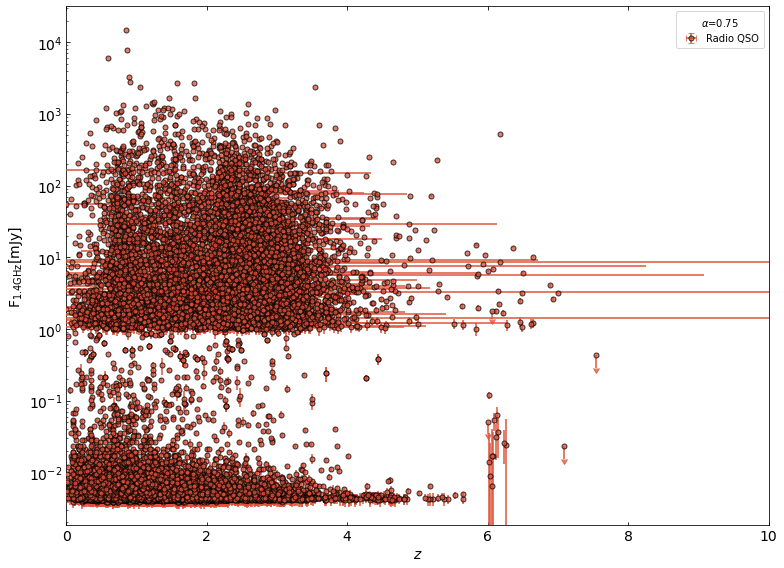

In [83]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.errorbar(redshift, merged_flux_catalog_df['Flux 1.4-1.7 GHz'], xerr=redshift_e, yerr=F_20cm_e, marker='.',\
             ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=F_20cm_up_l, elinewidth=2,\
             mec='k', label='Radio QSO')
# ax1.errorbar(redshift, L_20cm, xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[4],\
# markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')

# ax1.errorbar(high_z_zs[filter_250GHz], lum_250_new_alpha_rescale[filter_250GHz], yerr=lum_250_new_alpha_rescale_e[filter_250GHz],\
# marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2,\
# mec='k', label='mm QSO')

# ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
# ax1.plot(z_range, lum_5uJy, label='5 $\mu$Jy', color=colors[1], path_effects=pe1)
# ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[2], path_effects=pe1)
# ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[3], path_effects=pe1)
# ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[4], path_effects=pe1)
# ax1.plot(z_range, lum_FIRST, label='FIRST (1 mJy)', color=colors[5], path_effects=pe1)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{F}_{1.4 \mathrm{GHz}} [\mathrm{mJy}]$', size=14)
ax1.set_yscale('log')
# ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=5.5, right=8)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)


# ax2 = ax1.twinx()
# ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
# ax2.set_ylim((1e23 * 5.9e-22, 1e29 * 5.9e-22))
# ax2.set_yscale('log')
# ax2.figure.canvas.draw()

#plt.setp(ax2.get_yticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=False, direction='in')
# ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
# ax2.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)

We can see a very noticeable gap in our source distribution.
From the calculations in **Amarantidis et al., 2019**, we can explain this behavior  
from the selection biases of the different surveys involved in the production of our catalog. 

---

# Plot individual features

Another option to display the data is using histograms.  
From the selection of one column, we can create a plot.

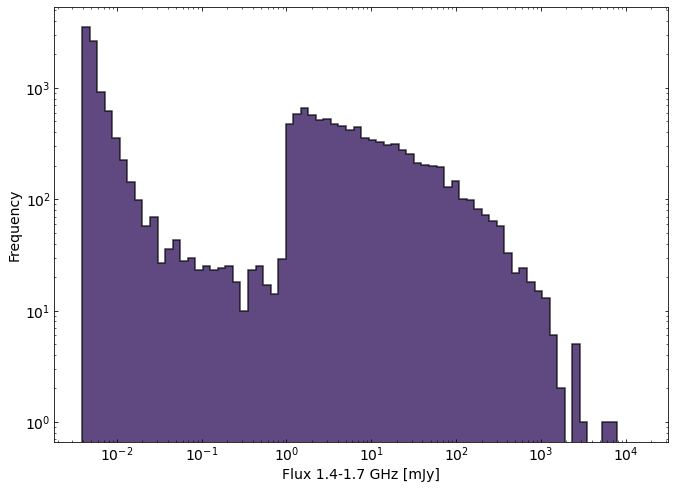

In [84]:
fig          = plt.figure(figsize=(11,8))
ax1          = fig.add_subplot(111)

col_name     = 'Flux 1.4-1.7 GHz'
col_name_str = col_name + ' [mJy]'

vmin_F       = np.log10(merged_flux_catalog_df[col_name].min())
vmax_F       = np.log10(merged_flux_catalog_df[col_name].max())
bins_F       = np.logspace(vmin_F, vmax_F, 75)

ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_xlabel(col_name_str, size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
merged_flux_catalog_df[col_name].plot.hist(color=colors[0], alpha=0.75, bins=bins_F, histtype='stepfilled', ec='k', lw=1.5)

For completeness, we can also create a histogram for the available redshift values.

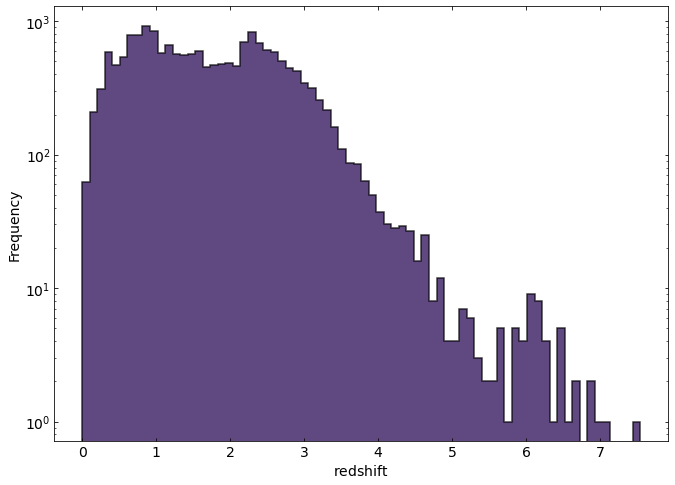

In [85]:
fig    = plt.figure(figsize=(11,8))
ax1    = fig.add_subplot(111)

vmin_z = redshift.min()
vmax_z = redshift.max()
bins_z = np.linspace(vmin_z, vmax_z, 75)

# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$\mathrm{redshift}$', size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
redshift.plot.hist(color=colors[0], alpha=0.75, bins=bins_z, histtype='stepfilled', ec='k', lw=1.5)

We can also select two luminosity columns and plot them. We can color-code them by redshift  
and include histograms for both quantities.

In [86]:
flux_names          = merged_flux_catalog_df.columns

In [87]:
add_histograms_flag = True  # Add histograms to the folowing plot

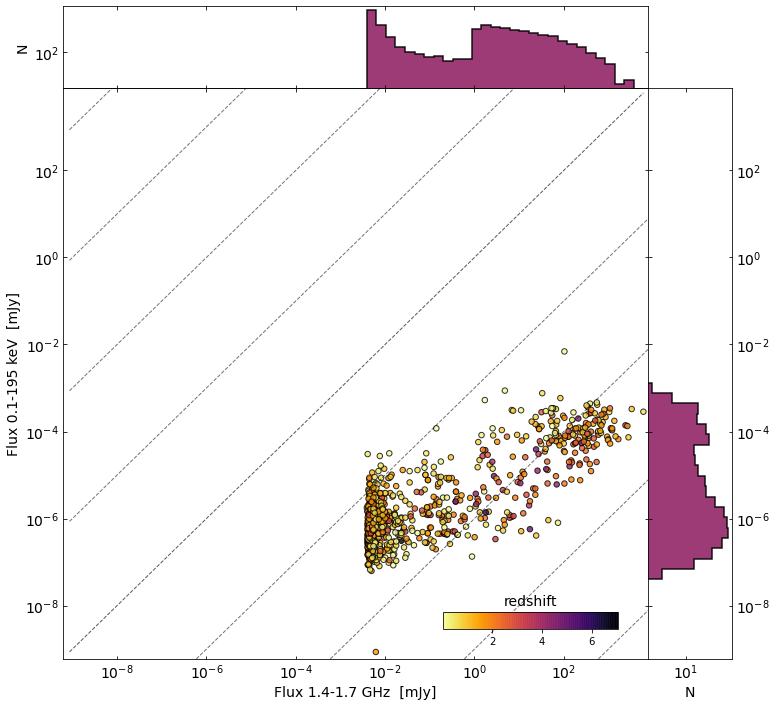

In [88]:
fig        = plt.figure(figsize=(12,12))

if not add_histograms_flag:
    ax1    = fig.add_subplot(111)

if add_histograms_flag:
    ax1    = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2    = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3    = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by number
# col_a = lum_names[0]
# col_b = lum_names[23]

# Select columns by name
col_a       = "Flux 1.4-1.7 GHz"
col_b       = "Flux 0.1-195 keV"

# Obtain luminosities and the cross-match between them
flux_a      = merged_flux_catalog_df[col_a]
flux_b      = merged_flux_catalog_df[col_b]
common_vals = np.multiply(flux_a, flux_b)

# Create log bins for log-scale histograms
min_val     = np.nanmin([flux_a[np.isfinite(common_vals)].min(), flux_b[np.isfinite(common_vals)].min()])
max_val     = np.nanmax([flux_a[np.isfinite(common_vals)].max(), flux_b[np.isfinite(common_vals)].max()])
bins_a      = np.logspace(np.log10(flux_a[np.isfinite(common_vals)].values.min()), np.log10(flux_a[np.isfinite(common_vals)].values.max()), 30)
bins_b      = np.logspace(np.log10(flux_b[np.isfinite(common_vals)].values.min()), np.log10(flux_b[np.isfinite(common_vals)].values.max()), 30)

ax1.set_yscale('log')
ax1.set_xscale('log')

# Format axis names and limits
if 'FLUX_' in col_a:
    col_a   = col_a.replace('FLUX_', 'Flux ') + ' (SIMBAD)'
if 'FLUX_' in col_b:
    col_b   = col_b.replace('FLUX_', 'Flux ') + ' (SIMBAD)'
ax1.set_xlabel(col_a + '  [mJy]', size=14)
ax1.set_ylabel(col_b + '  [mJy]', size=14)
ax1.set_ylim(min_val*0.7, max_val*1.3)
ax1.set_xlim(min_val*0.7, max_val*1.3)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)

sc          = ax1.scatter(flux_a, flux_b, c=redshift, cmap='inferno_r', s=30, alpha=0.80, edgecolor='black')

# Add 1-1 line and parallels for comparison
ax1.plot([min_val, max_val], [min_val, max_val], ls='dashed', color='k', alpha=0.65, lw=1)
for factor in [1e3, 1e6, 1e9, 1e12]:
    ax1.plot([min_val, max_val], [min_val*factor, max_val*factor], ls='dashed', color='k', alpha=0.55, lw=1)
    ax1.plot([min_val, max_val*factor], [min_val/factor, max_val], ls='dashed', color='k', alpha=0.55, lw=1)

# Create colorbar and plot it
cbaxes      = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
clb         = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
# clb.set_label('redshift', size=14)
clb.ax.set_title('redshift', size=14)

ax1.set_aspect('auto', share=False, adjustable='box')

if add_histograms_flag:
    # Plot vertical histogram
    hist(flux_b.values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9, color=dark_color,\
         ec='k', lw=1.5, hatch='')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('N', size=14)
    
    # Plot horizontal histogram
    hist(flux_a.values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9, color=dark_color,\
         ec='k', lw=1.5, hatch='')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel('N', size=14)
    
    # Modify ticks
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
    ax3.tick_params(which='both',top=True, right=True, direction='in')
    
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

---

# Obtain most highly correlated quantities

Make use of tools from `pandas` to calculate correlations between  
the flux columns and find the highest values.  
Pandas default behavior calculates the Pearson correlation coefficient (Kendall Tau and Spearman coefficients are also available).  
Since we do not know the exact behavior of our features, we choose Spearman's correlation coefficient.  
It is a non-parametric test that assesses monotonic relationships (something more general than linear  
relationships, as Pearson's does).

An interesting by-product of favoring Spearman over Pearson is that, since we are, mostly,  
visualizing our data in logarithmic scale, not only linear correlations can be spotted easily.  
Thus, what we can see (graphically) can match better the correlation values.

We can choose how many elements (sources) can be used for calculations. In our case,  
we want to use all of them.

It is also possible to avoid correlation calculations for columns with too few  
elements. The variable `min_elements` has been set to $20$ to this end.

In [89]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols    = 534    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements   = 20
# corr           = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr           = merged_flux_catalog_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs       = corr.abs()

In the following code block, the names of the pairs of columns with the  
highest correlations (and their values) are retrieved.

In [90]:
cols_corr      = (corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

It is recommended to drop (not using) columns with correlation values too close to one  
($1.0$) as they do not add new information to the analysis. The variable `corr_thresh` will  
limit the correlation values which will be discarded. In general, values above $0.7$ should  
be discarded. But, since we want to explore any possible correlation between our measurements,  
we can keep a higher value. As a matter of fact, we do want to discover these correlations.

The variable `num_of_corr` selects the number of high correlation pairs of columns we want to analyze at a time.  
This is purely for visualization purposes.

In [91]:
corr_thresh    = 0.90  # We want pairs with correlations below this value (0.78, 0.98, etc.)
num_of_corr    = 50    # How many high correlations we want to analyze at a time

In [92]:
arr_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [93]:
cols_corr[cols_corr<corr_thresh][:num_of_corr]

Flux I               Flux B                 0.878464
Flux K               Flux 3-8 microns       0.875641
Flux I               Flux r                 0.868917
Flux K               Flux V                 0.866362
Flux g               Flux u                 0.866218
Flux Y               Flux V                 0.865484
                     Flux FUV               0.862324
                     Flux g                 0.861417
                     Flux 3-8 microns       0.849743
Flux 1.4-1.7 GHz     Flux 7.7-163.1 GHz     0.832467
Flux J               Flux V                 0.832278
Flux g               Flux FUV               0.830898
Flux Y               Flux r                 0.827746
Flux i               Flux g                 0.821224
Flux 203-375 GHz     Flux 0.1-195 keV       0.815712
Flux V               Flux g                 0.810988
Flux J               Flux Y                 0.808599
                     Flux B                 0.807441
Flux K               Flux i                 0.

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

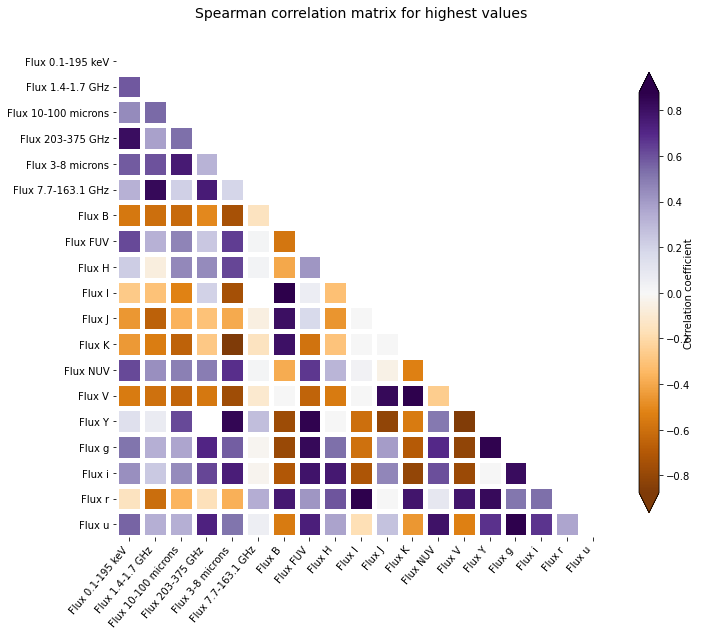

In [94]:
fig       = plt.figure(figsize=(12,9))
ax1       = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr.loc[cols_high_corr, cols_high_corr], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr  = corr.loc[cols_high_corr, cols_high_corr]
# arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
# arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr  = corr.loc[cols_high_corr, cols_high_corr].mask(mask_corr)
arr_corr[arr_corr > corr_thresh] = 0
arr_corr[arr_corr < -corr_thresh] = 0

vmin      = np.nanmin(arr_corr[arr_corr > -corr_thresh].values)
vmax      = np.nanmax(arr_corr[arr_corr < corr_thresh].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=0.1, vmax=vmax, midpoint=midpoint)

cax       = ax1.matshow(arr_corr, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar      = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks     = np.arange(0,len(cols_high_corr.tolist()),1)
ax1.set_xticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

To compare these results, we can calculate the correlation matrix using Pearson's  
coefficient.

In [95]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
min_elements   = 20

corr_alt       = merged_flux_catalog_df.loc[:num_of_rows].corr(min_periods=min_elements, method='pearson')
corr_alt_abs   = corr_alt.abs()

Names of the pairs of columns with the  
highest correlations (and their values).

In [96]:
cols_alt_corr  = (corr_alt_abs.where(np.triu(np.ones(corr_alt_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

In [97]:
arr_alt_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_alt = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [98]:
cols_alt_corr[cols_alt_corr<corr_thresh][:num_of_corr]

Flux 7.7-163.1 GHz   Flux 203-375 GHz       0.887603
Flux I               Flux 0.1-195 keV       0.862057
Flux 2.2-5.5 GHz     Flux 7.7-163.1 GHz     0.854886
Flux B               Flux u                 0.851224
Flux 10-968 MHz      Flux 1.4-1.7 GHz       0.811567
Flux K               Flux V                 0.794583
Flux I               Flux i                 0.728966
Flux H               Flux I                 0.697618
Flux 2.2-5.5 GHz     Flux 203-375 GHz       0.697224
Flux 10-968 MHz      Flux 2.2-5.5 GHz       0.692805
Flux K               Flux J                 0.667844
Flux J               Flux V                 0.660504
Flux 1.4-1.7 GHz     Flux 7.7-163.1 GHz     0.655157
Flux Y               Flux 3-8 microns       0.635865
                     Flux FUV               0.603869
Flux 2.2-5.5 GHz     Flux 0.1-100 GeV       0.584900
Flux 203-375 GHz     Flux 0.1-195 keV       0.581985
Flux i               Flux 203-375 GHz       0.578123
Flux u               Flux 203-375 GHz       0.

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

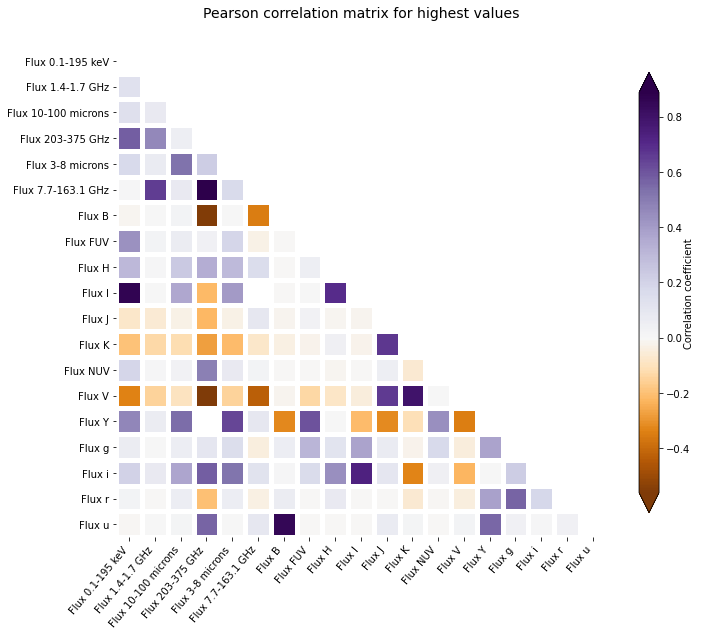

In [99]:
fig       = plt.figure(figsize=(12,9))
ax1       = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr  = corr.loc[cols_high_corr, cols_high_corr]
# arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
# arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr  = corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].mask(mask_corr)
arr_corr[arr_corr > corr_thresh] = 0
arr_corr[arr_corr < -corr_thresh] = 0

vmin      = np.nanmin(arr_corr[arr_corr > -corr_thresh].values)
vmax      = np.nanmax(arr_corr[arr_corr < corr_thresh].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax       = ax1.matshow(arr_corr, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar      = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks     = np.arange(0,len(cols_high_corr_alt.tolist()),1)
ax1.set_xticks(np.arange(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr_alt, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr_alt)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Pearson correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Assess blank spaces

For future calculations, and given the large amount of blank spaces seen in  
the correlation matrix plot, we also want to understand the level of sparsity of our sample.  
We use the package `missingno` to represent how many values are missing  
in our catalog.

First, we calculate the level of *completeness* (how many sources have valid measurements) of each column for the whole dataset.

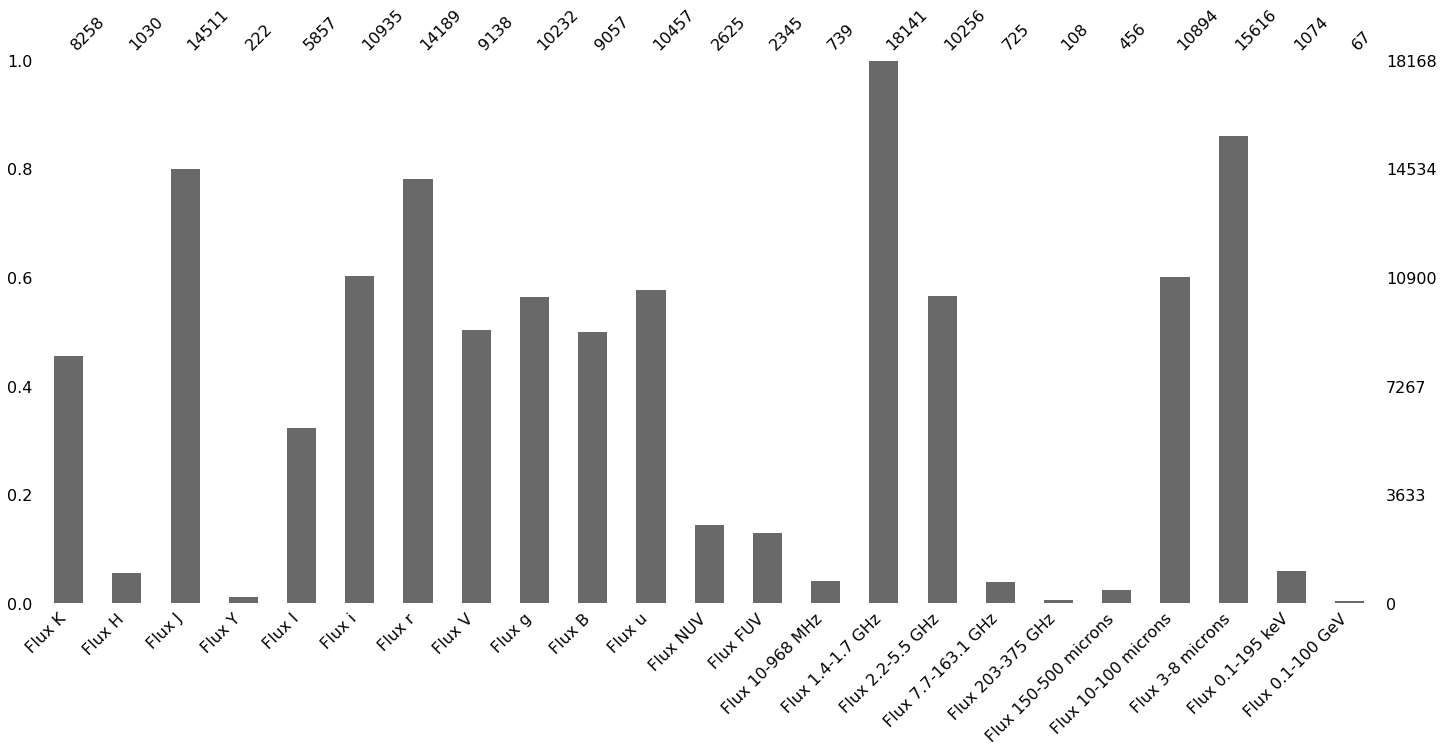

In [100]:
# msno.matrix(merged_lums_catalog_df)
msno.bar(merged_flux_catalog_df)

Now, we do it for only the most highly correlated columns.

In [101]:
# used_data = pd.DataFrame(merged_flux_catalog_df[cols_high_corr])
used_data = pd.DataFrame(merged_flux_catalog_df)

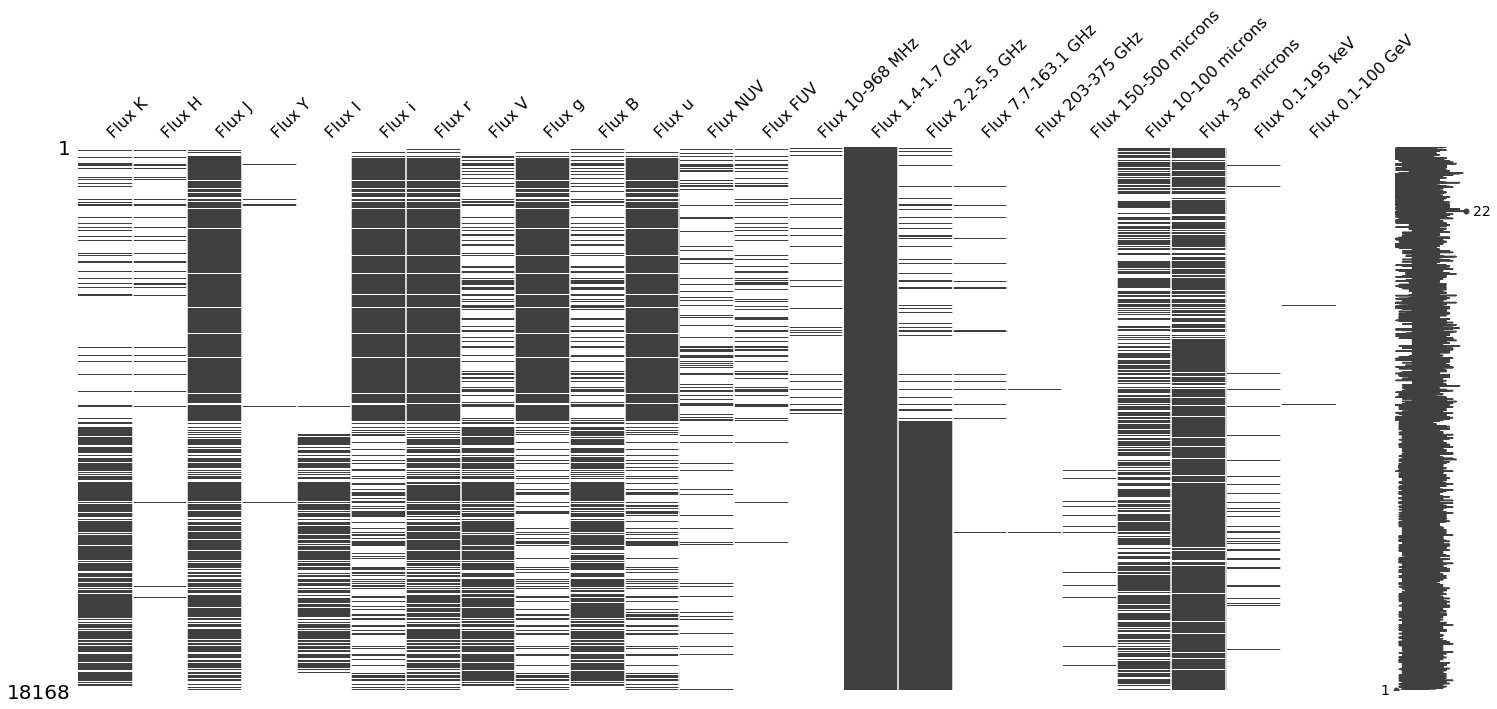

In [102]:
msno.matrix(used_data)

The right-most column in the chart shows the general shape of the data *completeness* of each selected row.  
It also points out the rows with the maximum and minimum nullity in the dataset.

This package allows us also to plot how correlated are the correlated behaviors  
of absence or presence of data for pairs of columns. A dendrogram can be plotted to  
understand any correlation in the lack of data.

In [103]:
# msno.dendrogram(merged_flux_catalog_df[cols_high_corr])

Numerically, we can also show the percentage of values in each column populated with NaN values.

For the columns with less invalid values, we have:

In [104]:
(merged_flux_catalog_df.isnull().sum()/len(merged_flux_catalog_df)*100).sort_values(ascending=True)[:25]

Flux 1.4-1.7 GHz         0.148613
Flux 3-8 microns        14.046675
Flux J                  20.128798
Flux r                  21.901145
Flux i                  39.811757
Flux 10-100 microns     40.037428
Flux u                  42.442756
Flux 2.2-5.5 GHz        43.549097
Flux g                  43.681198
Flux V                  49.702774
Flux B                  50.148613
Flux K                  54.546455
Flux I                  67.761999
Flux NUV                85.551519
Flux FUV                87.092690
Flux 0.1-195 keV        94.088507
Flux H                  94.330691
Flux 10-968 MHz         95.932409
Flux 7.7-163.1 GHz      96.009467
Flux 150-500 microns    97.490092
Flux Y                  98.778071
Flux 203-375 GHz        99.405548
Flux 0.1-100 GeV        99.631220
dtype: float64

And, for the features with the highest number of invalid entries:

In [105]:
# (merged_flux_catalog_df.isnull().sum()/len(merged_flux_catalog_df)*100).sort_values(ascending=True)[-25:]

---

# Impute empty values

Given the large proportion of empty (`NaN`) values in our dataset, we want to modify  
our table in order to make it easier to be analyzed by clustering algorithms or other type of ML codes.

Thus, we can replace non-numeric elements with some value. In this case, we choose zero ($0$) or $-99$ (as it is a very unlikely value in this context).

In [106]:
# backup_filled_flux_cat_df = filled_lums_cat_df.copy()
# filled_flux_cat_df = merged_flux_catalog_df.dropna(axis='columns', how='all')
# filled_flux_cat_df = filled_flux_cat_df.fillna(0)
# filled_flux_cat_df = filled_flux_cat_df.replace('inf', 0)

We can, also, replace the missing values with the mean of the selected column.

First, we discard columns containing less than one element.  
Some columns might have similar data (similar observational properties) and  
discarding before combining (in some way) them might have an impact in further calculations.

In [107]:
# filled_flux_cat_df = merged_flux_catalog_df.dropna(axis='columns', how='all')
filled_flux_cat_df = merged_flux_catalog_df.dropna(axis='columns', thresh=20)
col_names_non_drop = filled_flux_cat_df.columns

It is important to keep in mind that columns which have all their values as NaN  
might still have upper limits. These values have not been taken into account in this study.

Now, we replace the missing values.

In [108]:
# imputer       = SimpleImputer(missing_values=np.nan, strategy='median')
imputer       = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-99.00)
imputed_array = imputer.fit_transform(filled_flux_cat_df, filled_flux_cat_df)

Reassing the new (replaced) data into the old Table

In [109]:
filled_flux_cat_df = pd.DataFrame(imputed_array, columns=col_names_non_drop)

---

In [110]:
np.shape(merged_flux_catalog_df.columns)

(23,)

In [111]:
np.shape(filled_flux_cat_df.columns)

(23,)

---

# Recreate correlation matrix

Now, we can repeat parts of the previous procedures with our data.

The option `min_elements` tells the code to obtain the correlation matrix  
only for pairs of columns with more than this number of elements in common.

In [112]:
num_of_rows      = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols      = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements     = 20
# corr             = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled      = filled_flux_cat_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs_filled  = corr_filled.abs()

Ordered list of highly correlated pairs of columns.

In [113]:
cols_corr_filled = (corr_abs_filled.where(np.triu(np.ones(corr_abs_filled.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [114]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [115]:
arr_cols_filled       = np.array([np.array(row) for row in cols_corr_filled.keys()[cols_corr_filled<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled = np.unique(np.concatenate((arr_cols_filled[:, 0], arr_cols_filled[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [116]:
cols_corr_filled[cols_corr_filled<corr_thresh][:num_of_corr]

Flux J               Flux r                 0.898916
Flux i               Flux u                 0.896198
Flux K               Flux V                 0.830489
                     Flux B                 0.799676
                     Flux I                 0.792440
Flux I               Flux V                 0.740790
                     Flux B                 0.730261
Flux J               Flux I                 0.728530
Flux 10-100 microns  Flux 3-8 microns       0.683639
Flux I               Flux r                 0.682136
Flux K               Flux 1.4-1.7 GHz       0.675515
Flux I               Flux 1.4-1.7 GHz       0.659678
Flux g               Flux 1.4-1.7 GHz       0.646143
Flux J               Flux B                 0.634214
                     Flux V                 0.631846
Flux K               Flux J                 0.621608
Flux u               Flux 1.4-1.7 GHz       0.620629
Flux i               Flux 3-8 microns       0.581350
Flux r               Flux B                 0.

To better understand the correlation values, we can plot a correlation matrix.   
Only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

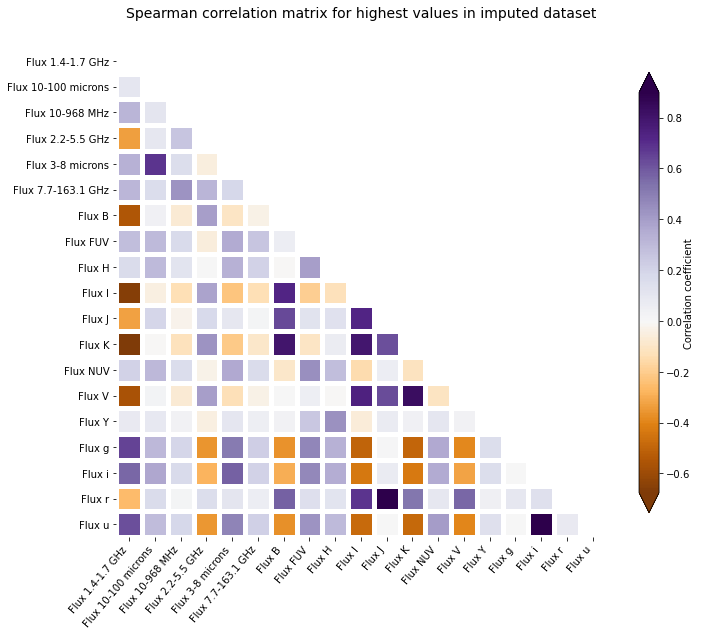

In [117]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled]
# arr_corr_filled[(arr_corr_filled > corr_thresh) & (arr_corr_filled < 1)] = 0
# arr_corr_filled[(arr_corr_filled < -corr_thresh) & (arr_corr_filled > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled].mask(mask_corr)
arr_corr_filled[arr_corr_filled > corr_thresh] = 0
arr_corr_filled[arr_corr_filled < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled[arr_corr_filled > -1].values)
vmax      = np.nanmax(arr_corr_filled[arr_corr_filled < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(cols_high_corr_filled.tolist()),1)
ax1.set_xticks(np.arange(arr_corr_filled.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr_filled, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr_filled)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values in imputed dataset', size=14)

ax1.set_aspect('equal')

Another change we can make is related to the position of the columns in the correlation matrix.  
It is possible to change their order to reflect possible clustering properties among  
them (using the highly correlated columns only).

In [118]:
# np.sum(corr_filled.isna())  # Number of NaN in each column

In [119]:
# corr_filled.dropna(axis='columns', how='any').dropna(axis='index', how='any')

In [120]:
X                      = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled].values
d                      = hc.distance.pdist(X)
L                      = hc.linkage(d, method='complete')
ind                    = hc.fcluster(L, 0.5*d.max(), 'distance')
ordered_columns_filled = [corr_filled[cols_high_corr_filled].columns.tolist()[i] for i in list((np.argsort(ind)))]
corr_filled_ordered    = corr_filled[cols_high_corr_filled].reindex(columns=ordered_columns_filled)
corr_filled_ordered    = corr_filled_ordered.reindex(index=ordered_columns_filled)

Now, we can replot the newly ordered correlation matrix.

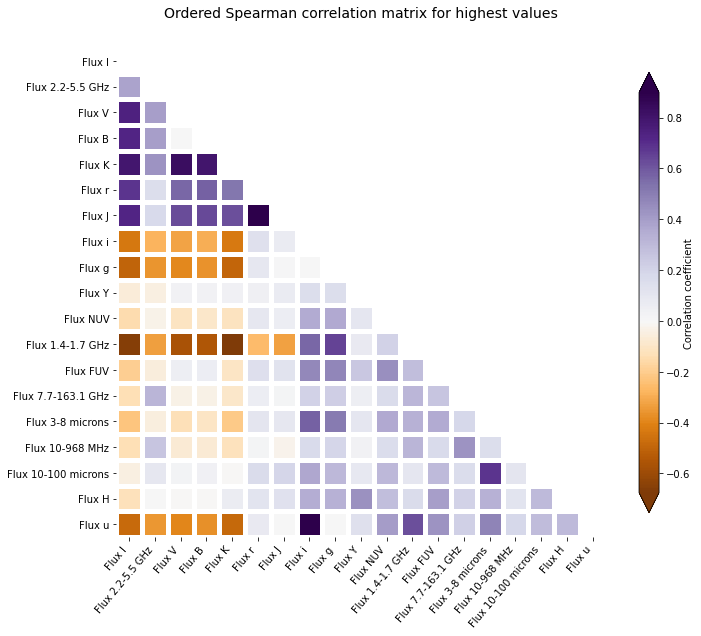

In [121]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled].mask(mask_corr)
arr_corr_filled_ordered[arr_corr_filled_ordered > corr_thresh] = 0
arr_corr_filled_ordered[arr_corr_filled_ordered < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered[arr_corr_filled_ordered > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered[arr_corr_filled_ordered < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Ordered Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Analyze feature relevance

Since the number of features our dataset has is high, we want to study their behavior  
in order to drop some of these features. Some algorithms have been developed to assess  
the importance of the information contained by each feature in the context of the overall  
behavior of the full sample.

A relevant measure of the quality of the variables (columns) we use has to do with  
their variance (or standard deviation). The differences between the variances among the columns  
should not be too high. When one column has too low variance, it does not add extra information  
to the overall table.

We can calculate the variances for all the columns.

In [122]:
order_variance        = filled_flux_cat_df.var().sort_values(ascending=False)
cols_ordered_variance = order_variance.index

Show the first $10$ elements.

In [123]:
order_variance[:10]

Flux FUV                6.966274e+23
Flux r                  1.395361e+22
Flux g                  3.754397e+21
Flux I                  9.028236e+20
Flux NUV                5.548330e+20
Flux u                  2.923173e+18
Flux 150-500 microns    1.666448e+18
Flux B                  1.069218e+17
Flux 10-968 MHz         1.418410e+05
Flux 1.4-1.7 GHz        2.505309e+04
dtype: float64

Show the last $10$ elements.

In [124]:
order_variance[-10:]

Flux K                 3429.751288
Flux 10-100 microns    2604.368681
Flux i                 2352.063789
Flux J                 1907.471405
Flux 203-375 GHz       1244.648521
Flux 3-8 microns       1189.816390
Flux 0.1-195 keV        545.165415
Flux H                  531.835127
Flux Y                  118.773731
Flux 0.1-100 GeV         36.012844
dtype: float64

These results can be seen graphically with the help of the Principal Component Analysis (`PCA`) algorithm.

In [125]:
pca = PCA()
pca.fit_transform(filled_flux_cat_df)
pca_variance = pca.explained_variance_

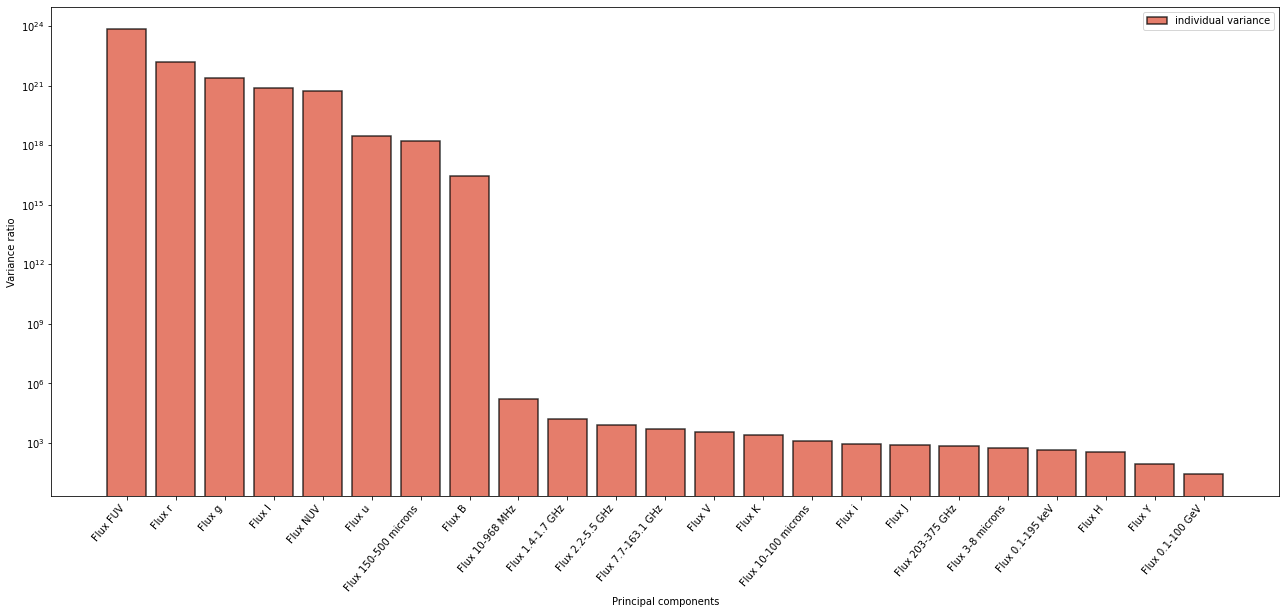

In [126]:
fig = plt.figure(figsize=(22,9))
ax1 = fig.add_subplot(111)

plt.bar(range(np.shape(cols_ordered_variance)[0]), pca_variance, alpha=0.75, align='center',\
        label='individual variance', color=colors[3], edgecolor='k', lw=1.5)
plt.legend()
ax1.set_ylabel('Variance ratio')
ax1.set_xlabel('Principal components')
ax1.set_yscale('log')
ticks = np.arange(0,len(cols_ordered_variance),1);
ax1.set_xticks(ticks);
ax1.set_xticklabels(cols_ordered_variance, rotation=50, horizontalalignment='right');

It can be seen that most of the variance of the dataset is explained by eight features  
(`FUV`, `NUV`, `g`, `150-500 microns`, `r`, `u`, `I`, `B`).  
The rest of features show variance values orders of magnitude lower (including `1.4-1.7 GHz`).

---

# Remove highly correlated features

We can remove the features which do not add extra information to our dataset.  
This can be achieved taking the most highly correlated pairs of columns and  
discarding the feature with the lowest variance (i.e., the least relevant feature).

Another reason to explore these features is that they might have too similar values.  
This can be an expression of the imputation of missing values since many entries  
show the same value (if the imputation has been applied with a constant value for all columns).

In [127]:
high_corr_thresh            = 0.95

In [128]:
high_corr_pairs             = cols_corr_filled[cols_corr_filled > high_corr_thresh]  # Already discarded self correlations

In [129]:
filled_flux_clean_df        = filled_flux_cat_df.copy()

cols_high_corr_filled_clean = np.unique(high_corr_pairs.index.tolist()).tolist()

In [130]:
cols_high_corr_filled_clean

['Flux g', 'Flux u']

In [131]:
np.shape(cols_high_corr_filled_clean)

(2,)

In [132]:
for pair in high_corr_pairs.index.to_list():
    col_a, col_b = pair
    if col_a not in cols_high_corr_filled_clean or col_b not in cols_high_corr_filled_clean: continue
    var_a = order_variance[col_a]
    var_b = order_variance[col_b]
    if var_a < var_b:
        filled_flux_clean_df.drop(col_a, inplace=True, axis='columns')
        cols_high_corr_filled_clean.remove(col_a)
        print('Removed column: ' + col_a)
    else:
        filled_flux_clean_df.drop(col_b, inplace=True, axis='columns')
        cols_high_corr_filled_clean.remove(col_b)
        print('Removed column: ' + col_b)

Removed column: Flux u


In [133]:
filled_flux_clean_df.shape

(18168, 22)

In [134]:
np.shape(cols_high_corr_filled_clean)

(1,)

Thus, we have removed $1$ feature from our dataset.  
Our sample now displays $22$ features.

---

# Repeat previous calculations

Now, we can obtain the correlation matrix and all its by-products  
as previously shown.

In [135]:
num_of_rows            = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols            = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements           = 20
# corr                   = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled_clean      = filled_flux_clean_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs_filled_clean  = corr_filled_clean.abs()

Ordered list of highly correlated pairs of columns.

In [136]:
cols_corr_filled_clean = (corr_abs_filled_clean.where(np.triu(np.ones(corr_abs_filled_clean.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [137]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [138]:
arr_cols_filled_clean       = np.array([np.array(row) for row in cols_corr_filled_clean.keys()[cols_corr_filled_clean<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled_clean = np.unique(np.concatenate((arr_cols_filled_clean[:, 0], arr_cols_filled_clean[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [139]:
cols_corr_filled_clean[cols_corr_filled_clean<corr_thresh][:num_of_corr]

Flux J               Flux r                 0.898916
Flux K               Flux V                 0.830489
                     Flux B                 0.799676
                     Flux I                 0.792440
Flux I               Flux V                 0.740790
                     Flux B                 0.730261
Flux J               Flux I                 0.728530
Flux 10-100 microns  Flux 3-8 microns       0.683639
Flux I               Flux r                 0.682136
Flux K               Flux 1.4-1.7 GHz       0.675515
Flux I               Flux 1.4-1.7 GHz       0.659678
Flux g               Flux 1.4-1.7 GHz       0.646143
Flux J               Flux B                 0.634214
                     Flux V                 0.631846
Flux K               Flux J                 0.621608
Flux i               Flux 3-8 microns       0.581350
Flux r               Flux B                 0.581223
Flux i               Flux 1.4-1.7 GHz       0.568367
Flux r               Flux V                 0.

To better understand the correlation values, we can plot a correlation matrix.   
Only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

Change directlu the column order to reflect possible clustering properties among  
them (using the highly correlated columns only).

In [140]:
# np.sum(corr_filled.isna())  # Number of NaN in each column

In [141]:
# corr_filled.dropna(axis='columns', how='any').dropna(axis='index', how='any')

In [142]:
X_clean                      = corr_filled_clean.loc[cols_high_corr_filled_clean, cols_high_corr_filled_clean].values
d_clean                      = hc.distance.pdist(X_clean)
L_clean                      = hc.linkage(d_clean, method='complete')
ind_clean                    = hc.fcluster(L_clean, 0.5*d_clean.max(), 'distance')
ordered_columns_filled_clean = [corr_filled_clean[cols_high_corr_filled_clean].columns.tolist()[i] for i in list((np.argsort(ind_clean)))]
corr_filled_ordered_clean    = corr_filled_clean[cols_high_corr_filled_clean].reindex(columns=ordered_columns_filled_clean)
corr_filled_ordered_clean    = corr_filled_ordered_clean.reindex(index=ordered_columns_filled_clean)

Now, we can replot the newly ordered correlation matrix.

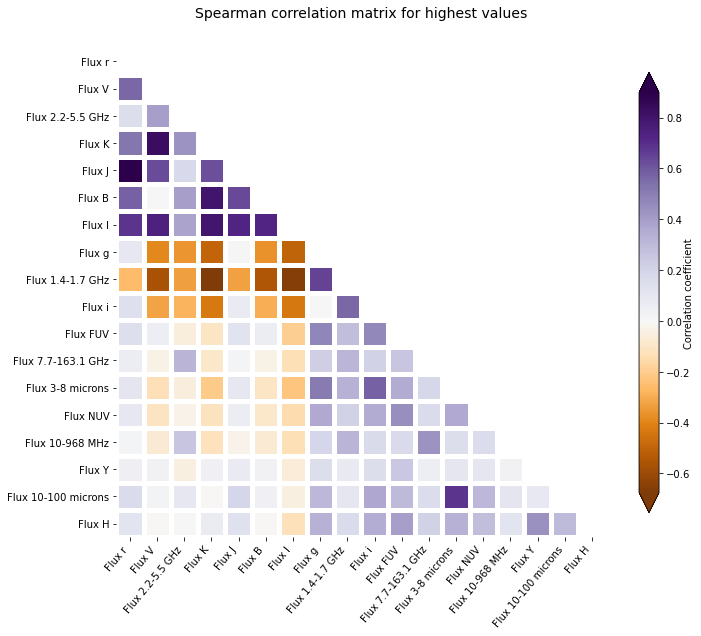

In [143]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered_clean.loc[ordered_columns_filled_clean, ordered_columns_filled_clean], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered_clean = corr_filled_ordered_clean.loc[ordered_columns_filled_clean, ordered_columns_filled_clean].mask(mask_corr)
arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean > corr_thresh] = 0
arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered_clean, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled_clean),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered_clean.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered_clean.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled_clean, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled_clean)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

Comparing that to the use of Pearson correlation values.

In [144]:
num_of_rows                = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols                = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements               = 20
# corr                       = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled_clean_alt      = filled_flux_clean_df.loc[:num_of_rows].corr(min_periods=min_elements, method='pearson')
corr_abs_filled_clean_alt  = corr_filled_clean_alt.abs()

Ordered list of highly correlated pairs of columns.

In [145]:
cols_corr_filled_clean_alt = (corr_abs_filled_clean_alt.where(np.triu(np.ones(corr_abs_filled_clean_alt.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [146]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [147]:
arr_cols_filled_clean_alt       = np.array([np.array(row) for row in cols_corr_filled_clean_alt.keys()[cols_corr_filled_clean_alt<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled_clean_alt = np.unique(np.concatenate((arr_cols_filled_clean_alt[:, 0], arr_cols_filled_clean_alt[:, 1])))  # Array with individual column names from highest correlations

In [148]:
X_clean_alt                      = corr_filled_clean_alt.loc[cols_high_corr_filled_clean_alt, cols_high_corr_filled_clean_alt].values
d_clean_alt                      = hc.distance.pdist(X_clean_alt)
L_clean_alt                      = hc.linkage(d_clean_alt, method='complete')
ind_clean_alt                    = hc.fcluster(L_clean_alt, 0.5*d_clean_alt.max(), 'distance')
ordered_columns_filled_clean_alt = [corr_filled_clean_alt[cols_high_corr_filled_clean_alt].columns.tolist()[i] for i in list((np.argsort(ind_clean_alt)))]
corr_filled_ordered_clean_alt    = corr_filled_clean_alt[cols_high_corr_filled_clean_alt].reindex(columns=ordered_columns_filled_clean_alt)
corr_filled_ordered_clean_alt    = corr_filled_ordered_clean_alt.reindex(index=ordered_columns_filled_clean_alt)

Now, we can replot the newly ordered correlation matrix.

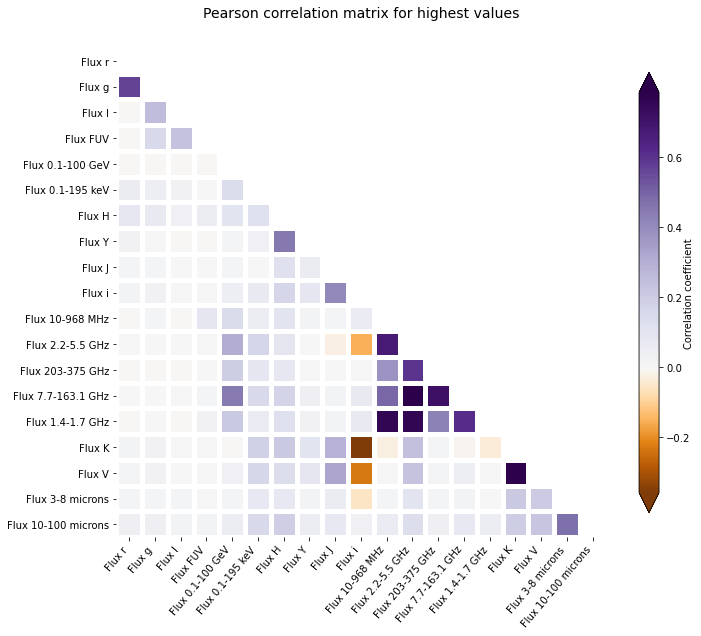

In [149]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered_clean_alt.loc[ordered_columns_filled_clean_alt, ordered_columns_filled_clean_alt], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered_clean_alt = corr_filled_ordered_clean_alt.loc[ordered_columns_filled_clean_alt, ordered_columns_filled_clean_alt].mask(mask_corr)
arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt > corr_thresh] = 0
arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered_clean_alt, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled_clean_alt),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered_clean_alt.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered_clean_alt.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled_clean_alt, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled_clean_alt)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Pearson correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Clustering calculations

As a way to extend our analysis, we can construct, and plot, the dendrogram for our data.  
This tool can be useful to determine possible clustering among the columns.

We are going to use the table with imputed values and with highly correlated features removed.

In [150]:
# generate the linkage matrix
Z = hc.linkage(filled_flux_clean_df, 'ward')

We plot a reduced version of the dendrogram.

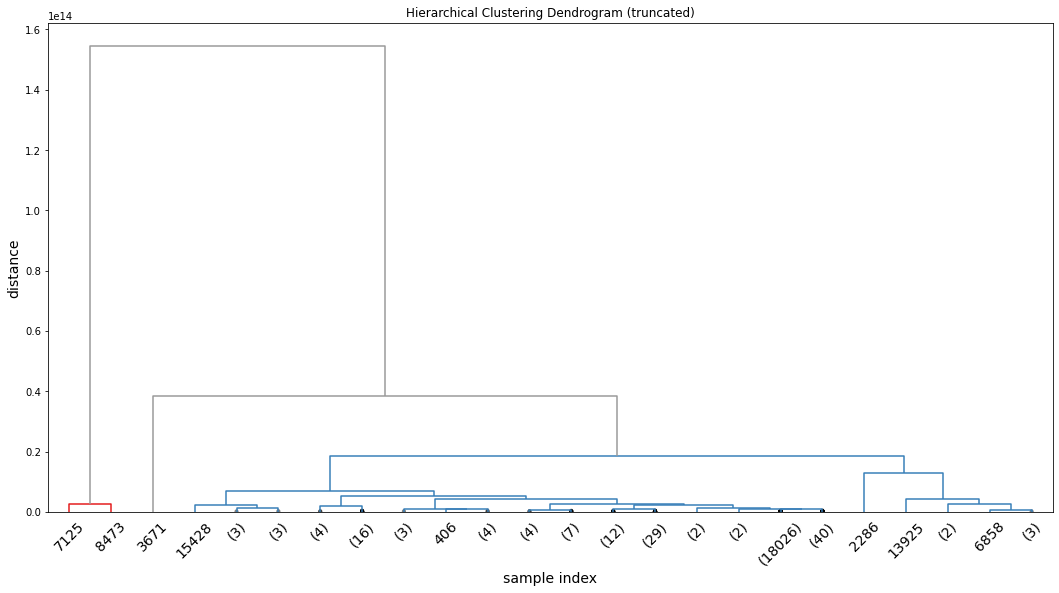

In [151]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(111)

# Custom color for branches
cmap_use   = cm.get_cmap('Set1')
cmap_array = cmap_use(np.linspace(0, 1, 10))
hc.set_link_color_palette([mcolors.rgb2hex(rgb[:3]) for rgb in cmap_array])

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index', size=14)
plt.ylabel('distance', size=14)
hc.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    # leaf_rotation=90.,
    color_threshold =0.2e14,
    above_threshold_color=cmap_use(1.0),  # color of first link
    leaf_font_size=14.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    orientation='top'
)

#plt.xscale('log')
plt.show()

# hc.set_link_color_palette(None)  # Reset color values

If we attempt to remove the four sources which are at the longest distances from the main *cluster*, that is,  
the elements not in blue and the first source in blue (`id:2286`), we obtain the following diagram.

In [152]:
filled_flux_clean_df_close = filled_flux_clean_df.drop([2286, 3671, 7125, 8473], axis='index')

In [153]:
# generate the linkage matrix
Z_close = hc.linkage(filled_flux_clean_df_close, 'ward')

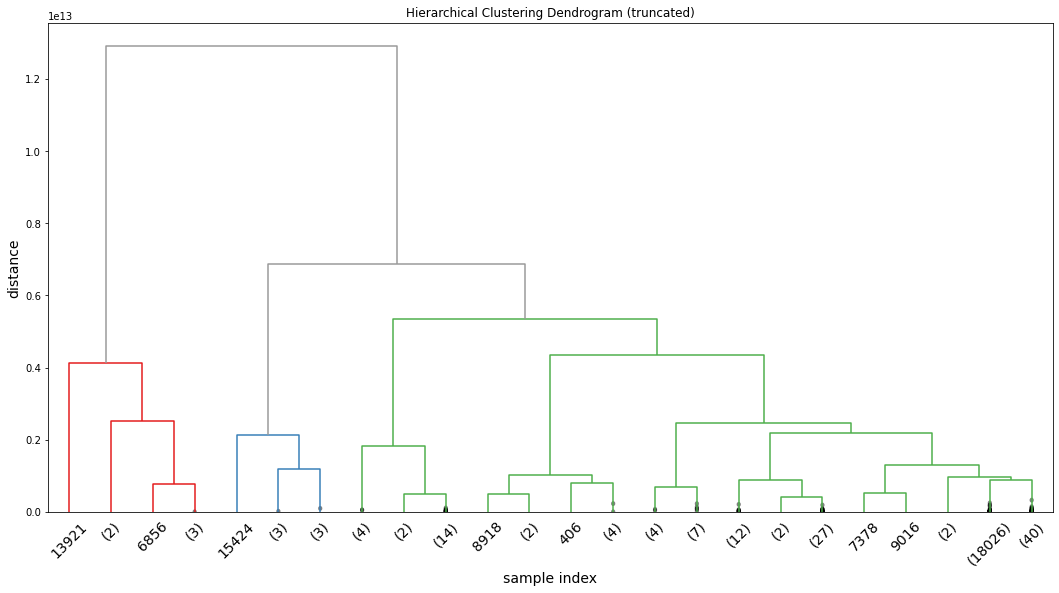

In [154]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(111)

# Custom color for branches
cmap_use   = cm.get_cmap('Set1')
cmap_array = cmap_use(np.linspace(0, 1, 10))
hc.set_link_color_palette([mcolors.rgb2hex(rgb[:3]) for rgb in cmap_array])

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index', size=14)
plt.ylabel('distance', size=14)
hc.dendrogram(
    Z_close,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    # leaf_rotation=90.,
    color_threshold =0.6e13,
    above_threshold_color=cmap_use(1.0),  # color of first link
    leaf_font_size=14.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    orientation='top'
)

#plt.xscale('log')
plt.show()

# hc.set_link_color_palette(None)  # Reset color values

One conclusion that can be drawn from the previous dendrogram is related to  
the fact that the most part of our sample is shown as part of one major cluster  
and the remaining elements are depicted as, mostly, outliers (distributed in two minor subsets).

Another option to find possible clusters within our data is using `t-SNE`  
(t-distributed Stochastic Neighbor Embedding, **van der Maaten and Hinton, 2008**) algorithms.  
A good guide for its use can be found in [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/).

In [155]:
X_tsne = TSNE(learning_rate=100, perplexity=35, n_iter=1500).fit_transform(filled_flux_clean_df_close)

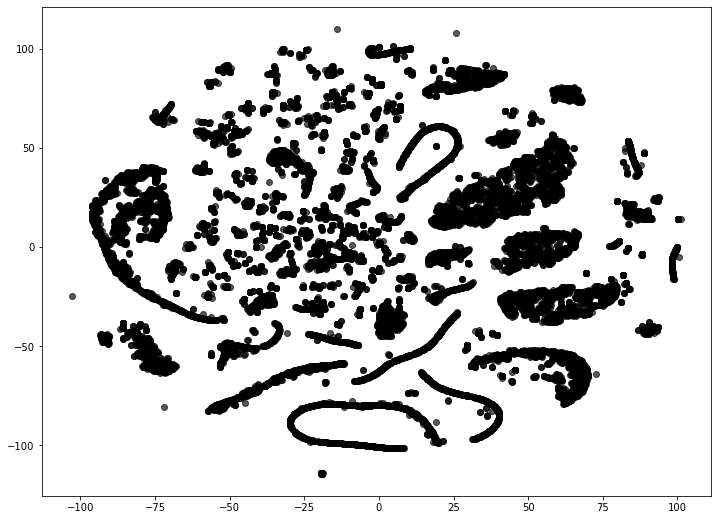

In [156]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c='k', alpha=0.65)

We can see that in the previous plot are several structures and isolated elements  
in the middle of these shapes. 

This might hint the presence of further clustering in our sample.

It is important to note that, in principle, distances between points do not hold any  
particular meaning. What is important is the overall distribution of elements.

---

# Obtain elements of clusters

From the previous dendrogram and the `t-SNE` plot, we can see that we have two distinct populations for our sample.  
With this number ($2$), we can use Agglomerative Clustering from `sklearn` to obtain the labels  
for our sources.

In [157]:
max_d         = 0.6e13
# max_d         = 0.2e14

In [158]:
cluster_agg   = AgglomerativeClustering(n_clusters=None, distance_threshold=max_d, affinity='euclidean', linkage='ward')  
agg_cluster   = cluster_agg.fit_predict(filled_flux_clean_df_close)

In [159]:
array_values_agg = []
for cluster_idx in np.unique(agg_cluster):
    array_values_agg.append([cluster_idx, np.sum(agg_cluster == (cluster_idx))])
array_values_agg = np.array(array_values_agg)

In [160]:
ordered_array_values_agg = array_values_agg[array_values_agg[:,1].argsort()[::-1]]

In [161]:
for cluster_idx in ordered_array_values_agg[:25]:
    print(f'Cluster id: {cluster_idx[0]}\tElements: {cluster_idx[1]}')

Cluster id: 0	Elements: 18150
Cluster id: 2	Elements: 7
Cluster id: 1	Elements: 7


We can also fetch the values from the previous execution of the Dendrogram calculation.

In [162]:
clusters_dend = hc.fcluster(Z_close, max_d, criterion='distance')

In [163]:
array_values_dend = []
for cluster_idx in np.unique(clusters_dend):
    array_values_dend.append([cluster_idx, np.sum(clusters_dend == (cluster_idx))])
array_values_dend = np.array(array_values_dend)

In [164]:
ordered_array_values_dend = array_values_dend[array_values_dend[:,1].argsort()[::-1]]

In [165]:
for cluster_idx in ordered_array_values_dend[:25]:
    print(f'Cluster id: {cluster_idx[0]}\tElements: {cluster_idx[1]}')

Cluster id: 3	Elements: 18150
Cluster id: 2	Elements: 7
Cluster id: 1	Elements: 7


Thus, we can see that the results from both methods deliver the same results. There is one large cluster with more than $99 \%$ of the elements from the full sample. And the rest is shared among several minor clusters which could be classified as *outliers*.

---

# Save new database into a file

In order to repeat these calculation and add new features,  
we save our luminosity data into a file. We also add a new column  
with the redshift ($z$) values for our sources.

It is important to remember that we are not taking into account the  
uncertainties from the luminosities and the redshifts.

In [166]:
save_clean_lums_flag = False

In [167]:
if save_clean_lums_flag:
    filled_flux_clean_df['z_val']  = redshift
    filled_flux_clean_df['origin'] = origin_flag

In [168]:
if save_clean_lums_flag:
    filled_flux_clean_df.to_hdf(cat_path + 'large_cat_flux_z_clean_jun2020.h5', 'df')